# Import libraries and data


In [10]:
#!pip install tbats
#%pip install plotly
#%pip install seaborn
%pip install sktime

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for sktime from https://files.pythonhosted.org/packages/f2/49/4f8b6321fe35a85a78913642d4b5052ab7d5faa23f5410051991301fe61d/sktime-0.33.0-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-base<0.10.0,>=0.6.1 from https://files.pythonhosted.org/packages/75/f3/fd6ba57b011eefef7d3213490c6b7d64e233990b2f7fc5b455a4de3f3176/scikit_base-0.9.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/34.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/34.4 MB 1.3 MB/s eta 0:00:27
   ---------------------------------------- 0.1/34.4 MB 1.3 MB/s eta 0:00:27
   ---------------------------------------- 0.2/34.4 MB 2.1 MB/s eta 0:00:17
    --------------------------------------- 0.5/34.4 MB 2.8 MB/s eta 0:00:13
    --------------------------------------- 0.7/34.4 MB 3.2 MB/s eta 0:00:11
    --------------------------------------- 0.7/34.4 MB 3.3 MB/s eta 0:00:11
   - -------------------------------------- 1.0/

In [1]:
%cd D://Flood Risk Churn-MF/Evaluacion del dataset 25001 para validacion de articulo/25001

D:\Flood Risk Churn-MF\Evaluacion del dataset 25001 para validacion de articulo\25001


C:\Users\ZM\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']=1.5
dark_style={
 'figure.facecolor':'#212946',
 'axes.facecolor':'#212946',
 'savefig.facecolor':'#212946',
 'axes.grid':True,
 'axes.grid.which':'both',
 'axes.spines.top':False,
 'axes.spines.bottom':False,
 'grid.color':'#2A3459',
 'grid.linewidth':'1',
 'text.color':'0.9',
 'axes.labelcolor':'0.9',
 'xtick.color':'0.9',
 'ytick.color':'0.9',
 'font.size':12
}
plt.rcParams.update(dark_style)


In [13]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.tbats import TBATS
from sktime.utils.plotting import plot_series

In [67]:
#get the data
data = pd.read_csv("25001_61_71.csv",
                   index_col="FECHA",
                   parse_dates=True)
data.head(5)

,PRECIP,EVAP,TMAX,TMIN,FECHA_AUX
FECHA,,,,,
01/01/1961,1.0,5.0,25.0,13.0,01/01/1961
02/01/1961,1.0,5.0,27.5,14.0,02/01/1961
03/01/1961,1.0,5.0,31.0,11.0,03/01/1961
04/01/1961,1.0,5.0,32.0,13.0,04/01/1961
05/01/1961,1.0,5.0,29.0,14.0,05/01/1961


In [5]:
data.index = pd.to_datetime(data.index,
                            format = "%d/%m/%Y")
data.head(2)   
data = data.asfreq("MS")
data.index              

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01',
               ...
               '1971-03-01', '1971-04-01', '1971-05-01', '1971-06-01',
               '1971-07-01', '1971-08-01', '1971-09-01', '1971-10-01',
               '1971-11-01', '1971-12-01'],
              dtype='datetime64[ns]', name='FECHA', length=132, freq='MS')

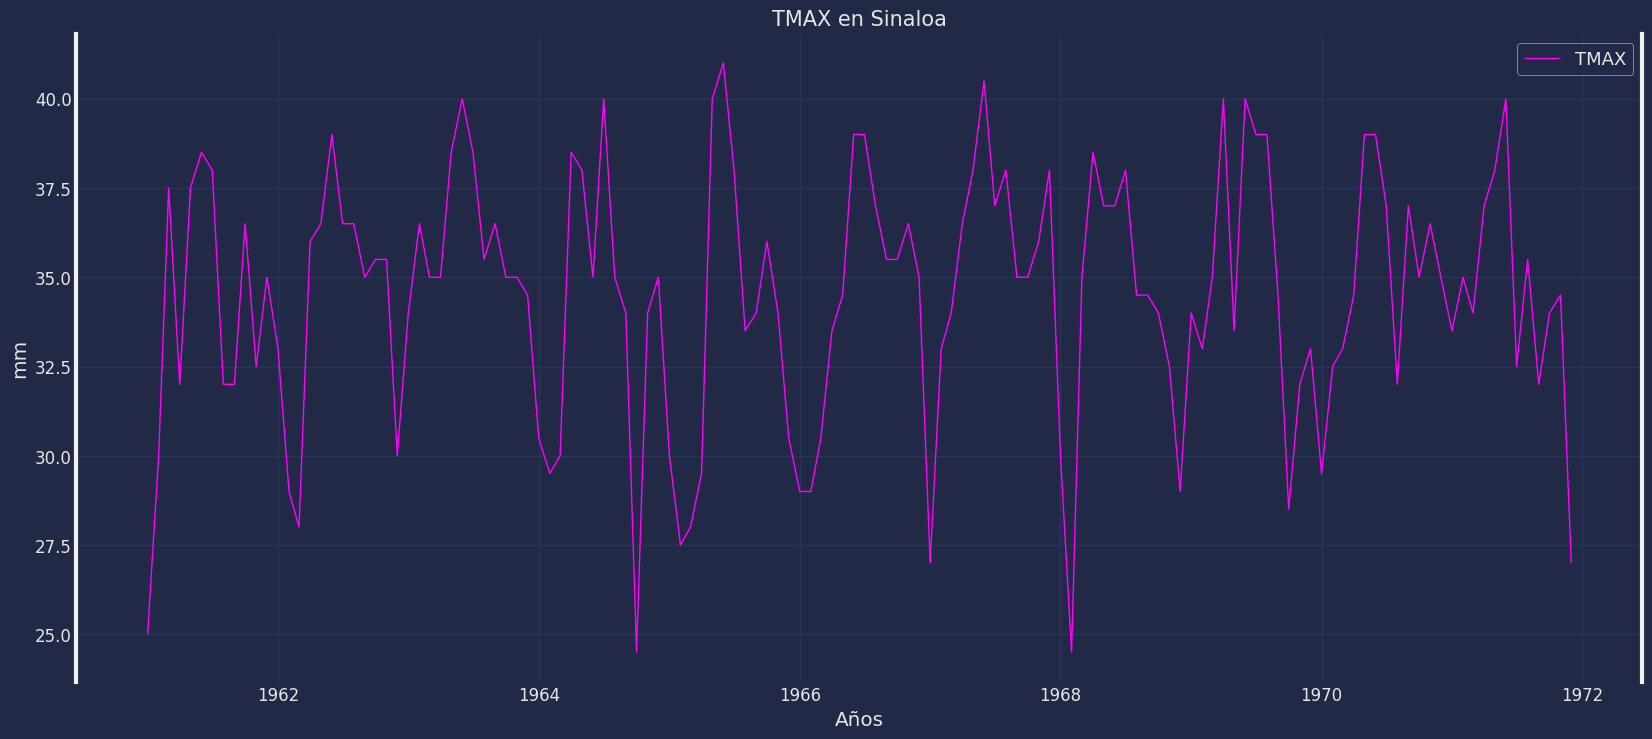

In [32]:
plt.figure(figsize=(18, 8))
plt.plot(data['TMAX'],color="Magenta",linewidth=1)
plt.title('TMAX en Sinaloa',fontsize=15)
plt.xlabel("Años")
plt.ylabel('mm')
plt.legend(['TMAX'],fontsize=13)
plt.show()

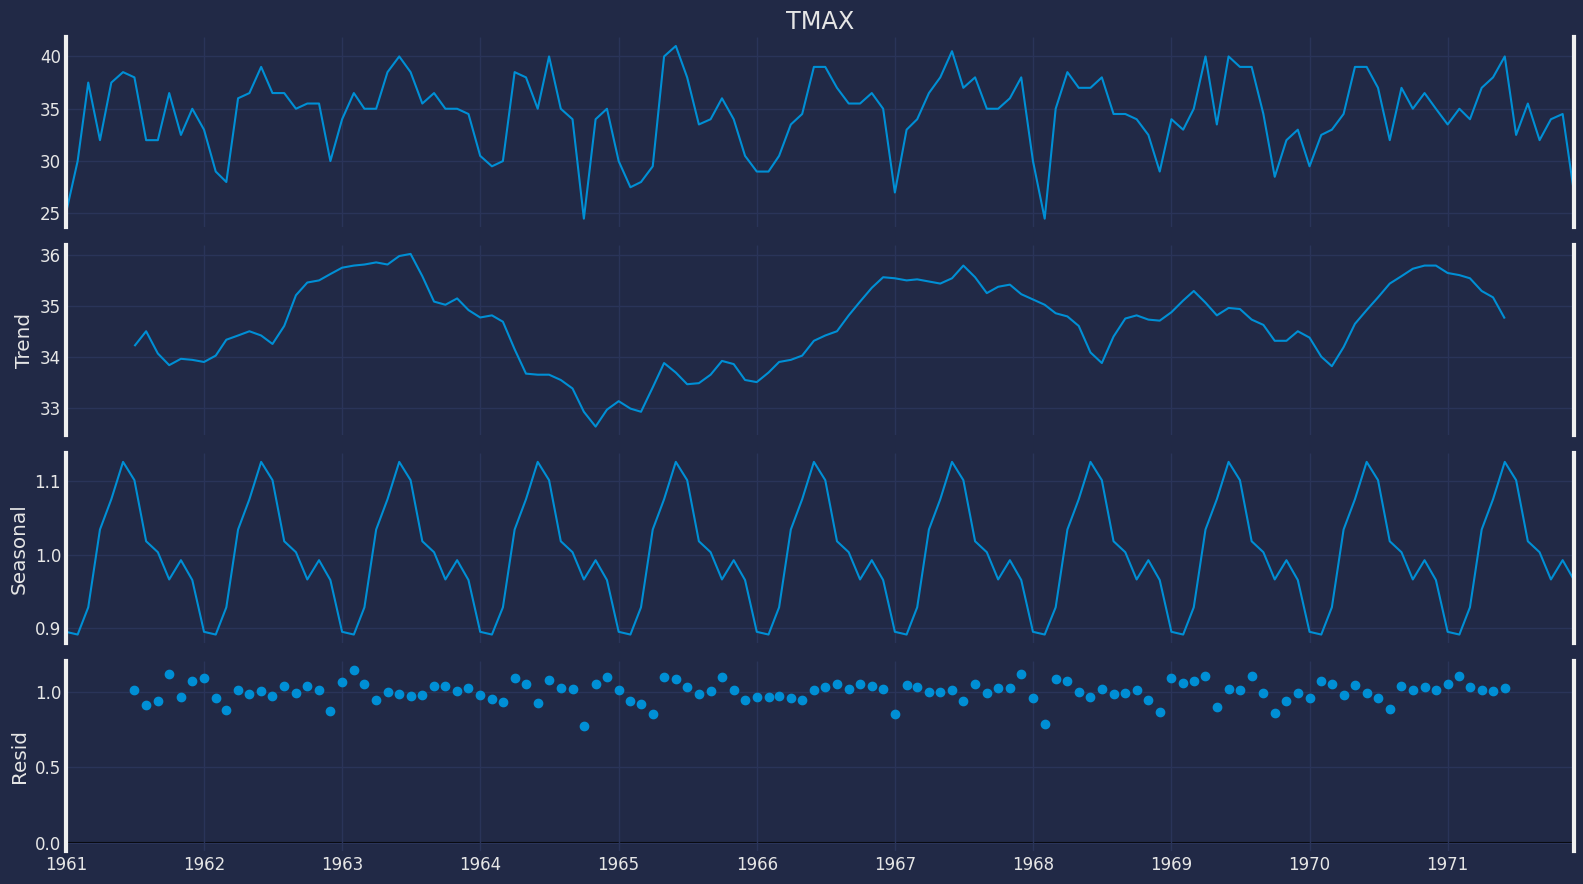

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
a=seasonal_decompose(data['TMAX'],model='multiplicative',period=12)
fig = a.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

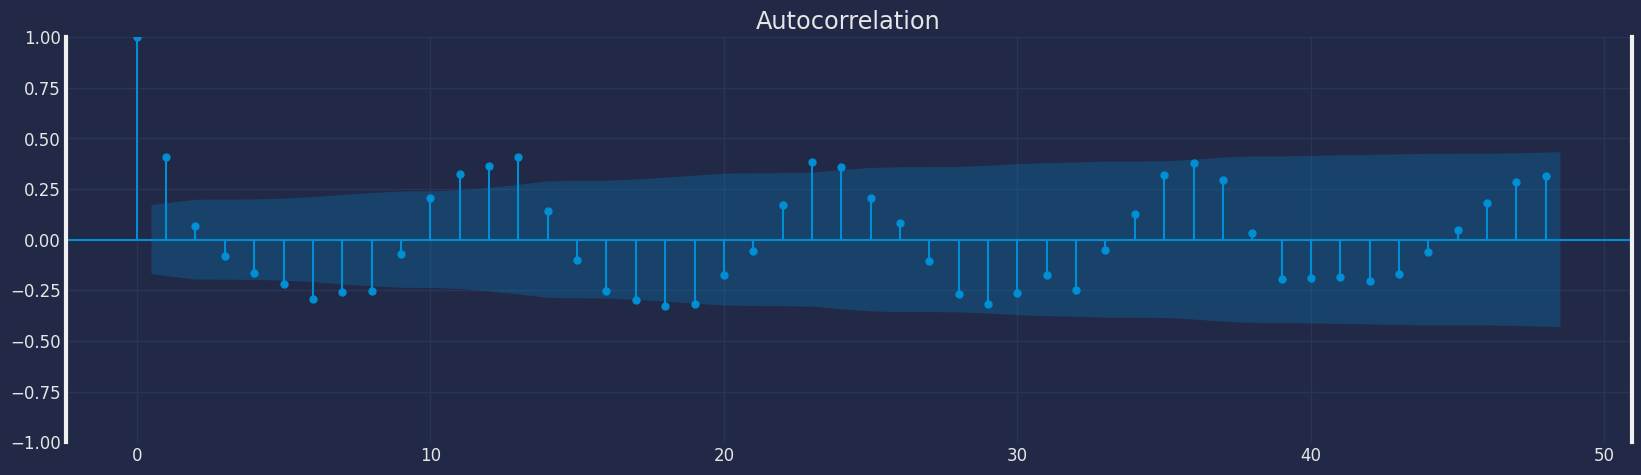

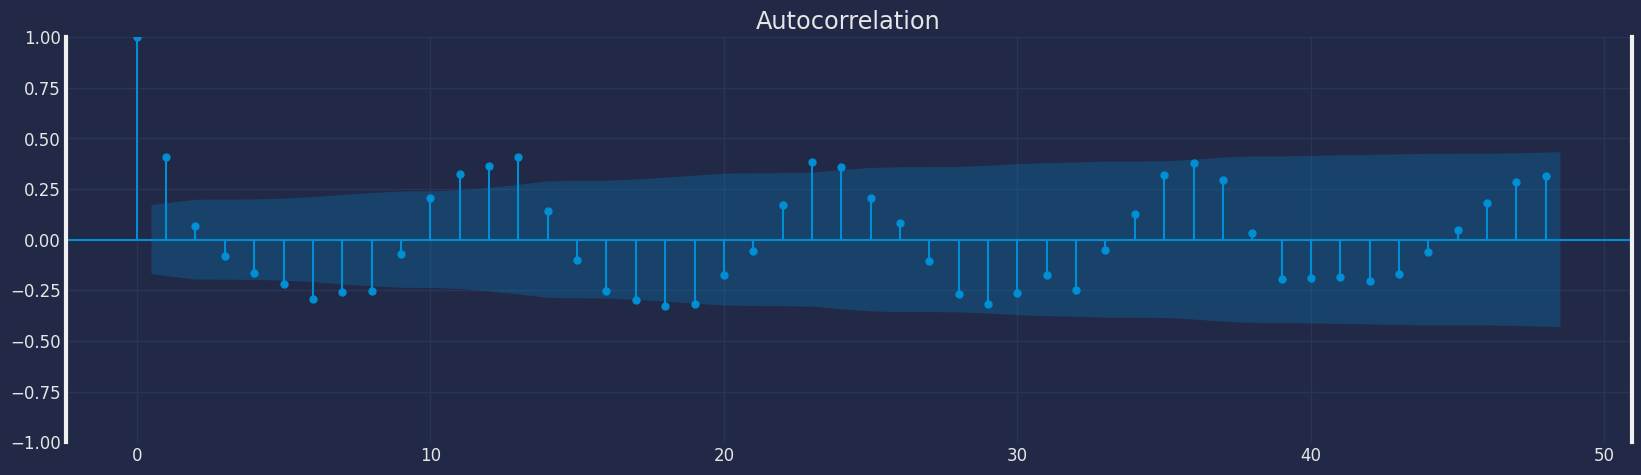

In [34]:
fig,ax=plt.subplots(figsize=(18,5))
plot_acf(data['TMAX'],lags=48,ax=ax)

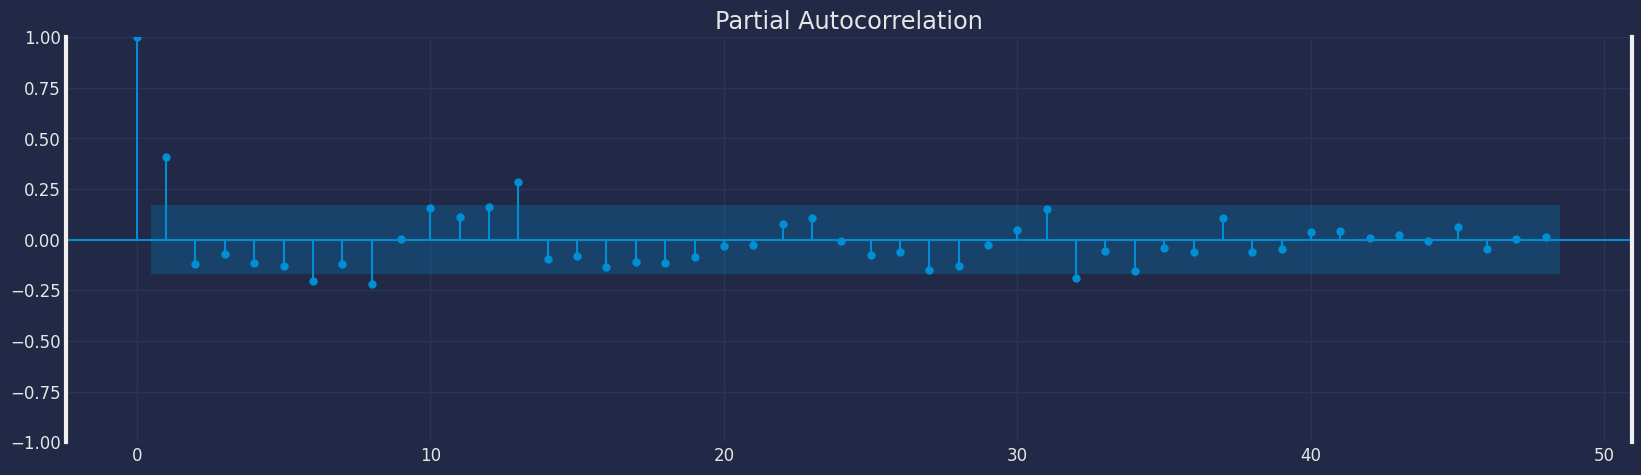

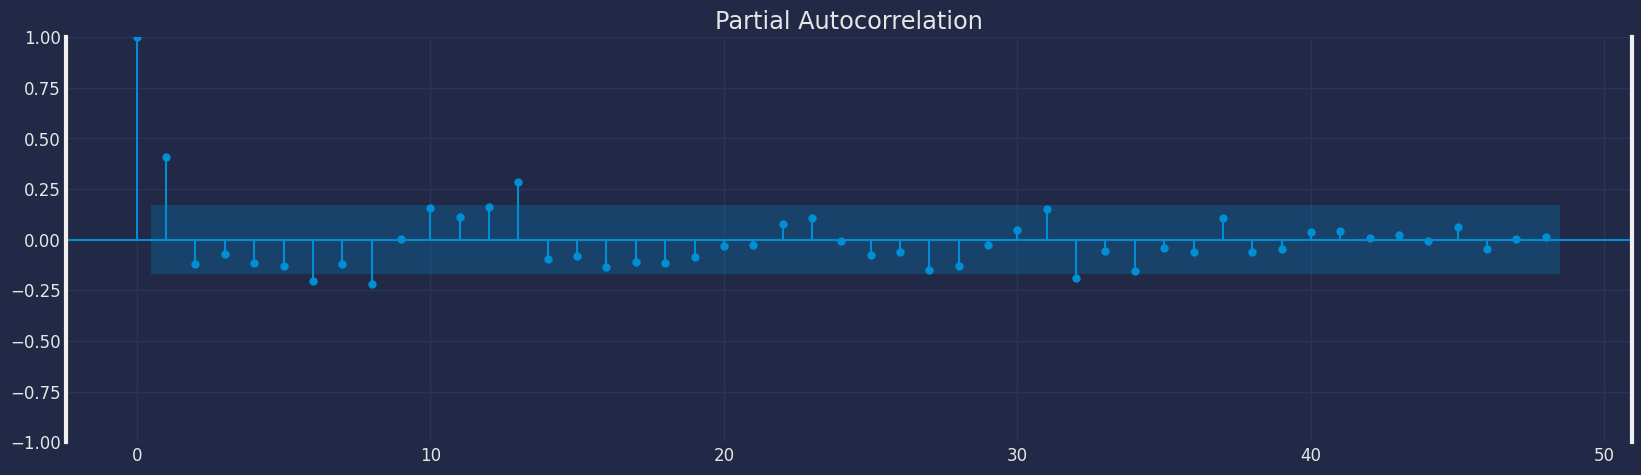

In [35]:
fig,ax=plt.subplots(figsize=(18,5))
plot_pacf(data['TMAX'],lags=48,ax=ax)

In [14]:
def metricas(y_true,y_pred,model_name):
    mae_=mean_absolute_error(y_true,y_pred)
    rmse_=mean_squared_error(y_true,y_pred,square_root=True)
    mape_=mean_absolute_percentage_error(y_true,y_pred)
    smape_=mean_absolute_percentage_error(y_true,y_pred,symmetric=True)
    dict_={'MAE':mae_,'RMSE_':rmse_,'MAPE':mape_,'SMAPE':smape_}
    metrica1=pd.DataFrame(dict_,index=[model_name])
    return(metrica1.round(decimals=2))

In [36]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['TMAX'],test_size=36)
y_train1, y_test1=temporal_train_test_split(data['TMAX'],test_size=36)
y_train.head(10)

FECHA
1961-01-01    25.0
1961-02-01    30.0
1961-03-01    37.5
1961-04-01    32.0
1961-05-01    37.5
1961-06-01    38.5
1961-07-01    38.0
1961-08-01    32.0
1961-09-01    32.0
1961-10-01    36.5
Freq: MS, Name: TMAX, dtype: float64

In [15]:
#Creando un modelo Base
forecaster=NaiveForecaster(strategy="last",sp=12)
forecaster.fit(y_train)

NaiveForecaster(sp=12)

In [37]:
forecaster_tbats=TBATS(use_box_cox=True,use_trend=True,use_damped_trend=True,sp=[12,48])
forecaster_tbats.fit(y_train)

TBATS(sp=[12, 48], use_box_cox=True, use_damped_trend=True, use_trend=True)

In [21]:
fh=ForecastingHorizon(y_test.index,is_relative=False)

In [38]:
y_preds_tbats=forecaster_tbats.predict(fh)
y_preds_tbats

FECHA
1969-01-01    28.379284
1969-02-01    28.113588
1969-03-01    30.748858
1969-04-01    34.226917
1969-05-01    37.001511
1969-06-01    38.489667
1969-07-01    37.934973
1969-08-01    35.616980
1969-09-01    33.839695
1969-10-01    34.029976
1969-11-01    34.244522
1969-12-01    32.196576
1970-01-01    29.261164
1970-02-01    28.650940
1970-03-01    30.956974
1970-04-01    34.181268
1970-05-01    36.826766
1970-06-01    38.341194
1970-07-01    37.975792
1970-08-01    35.993620
1970-09-01    34.661035
1970-10-01    35.352080
1970-11-01    36.061551
1970-12-01    34.439821
1971-01-01    31.809109
1971-02-01    31.347136
1971-03-01    33.628468
1971-04-01    36.657408
1971-05-01    38.959955
1971-06-01    40.023741
1971-07-01    39.149427
1971-08-01    36.651666
1971-09-01    34.842567
1971-10-01    35.128970
1971-11-01    35.522546
1971-12-01    33.674135
Freq: MS, Name: TMAX, dtype: float64

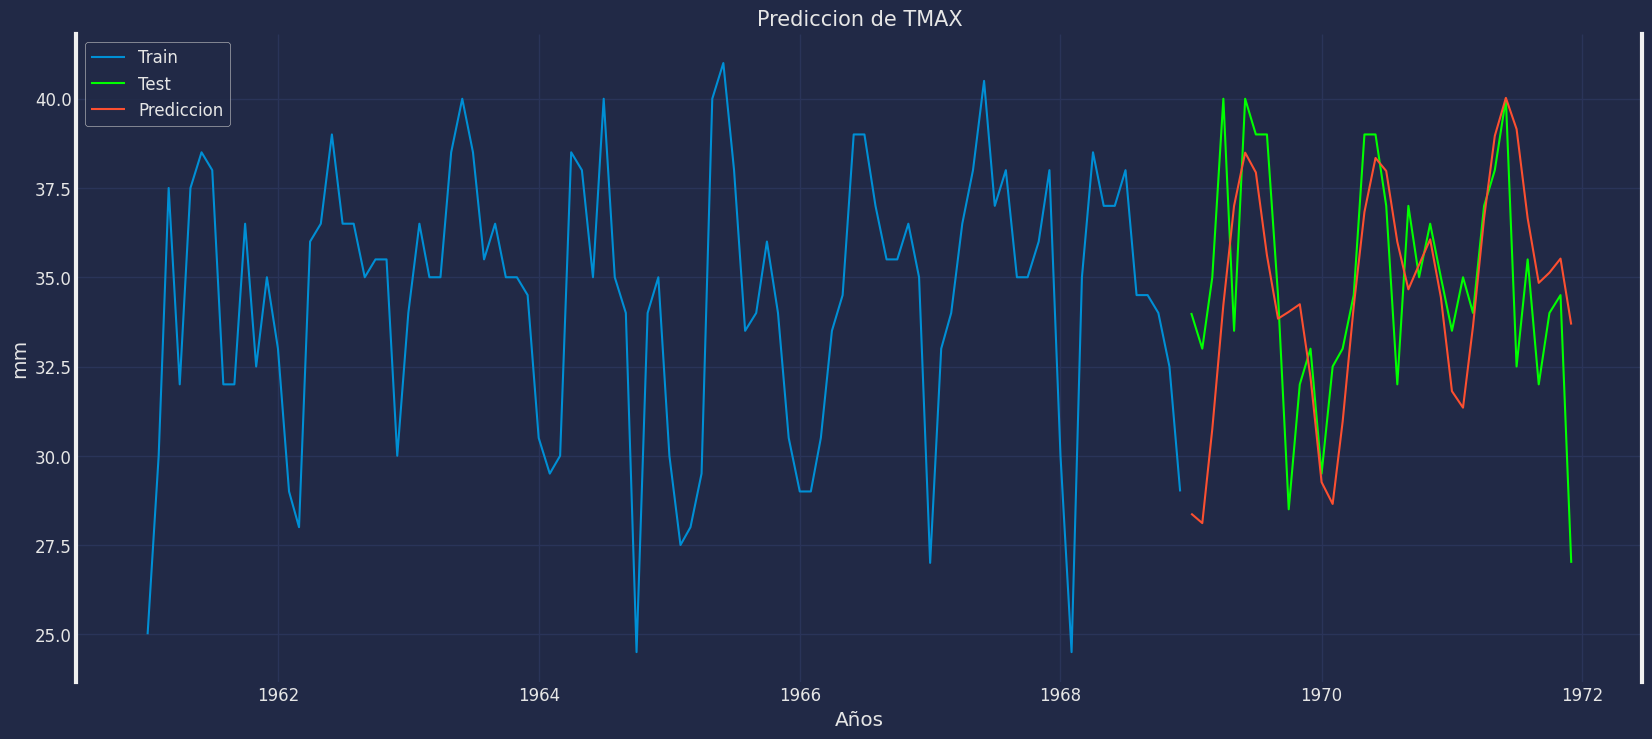

In [39]:
plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion")
plt.title("Prediccion de TMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

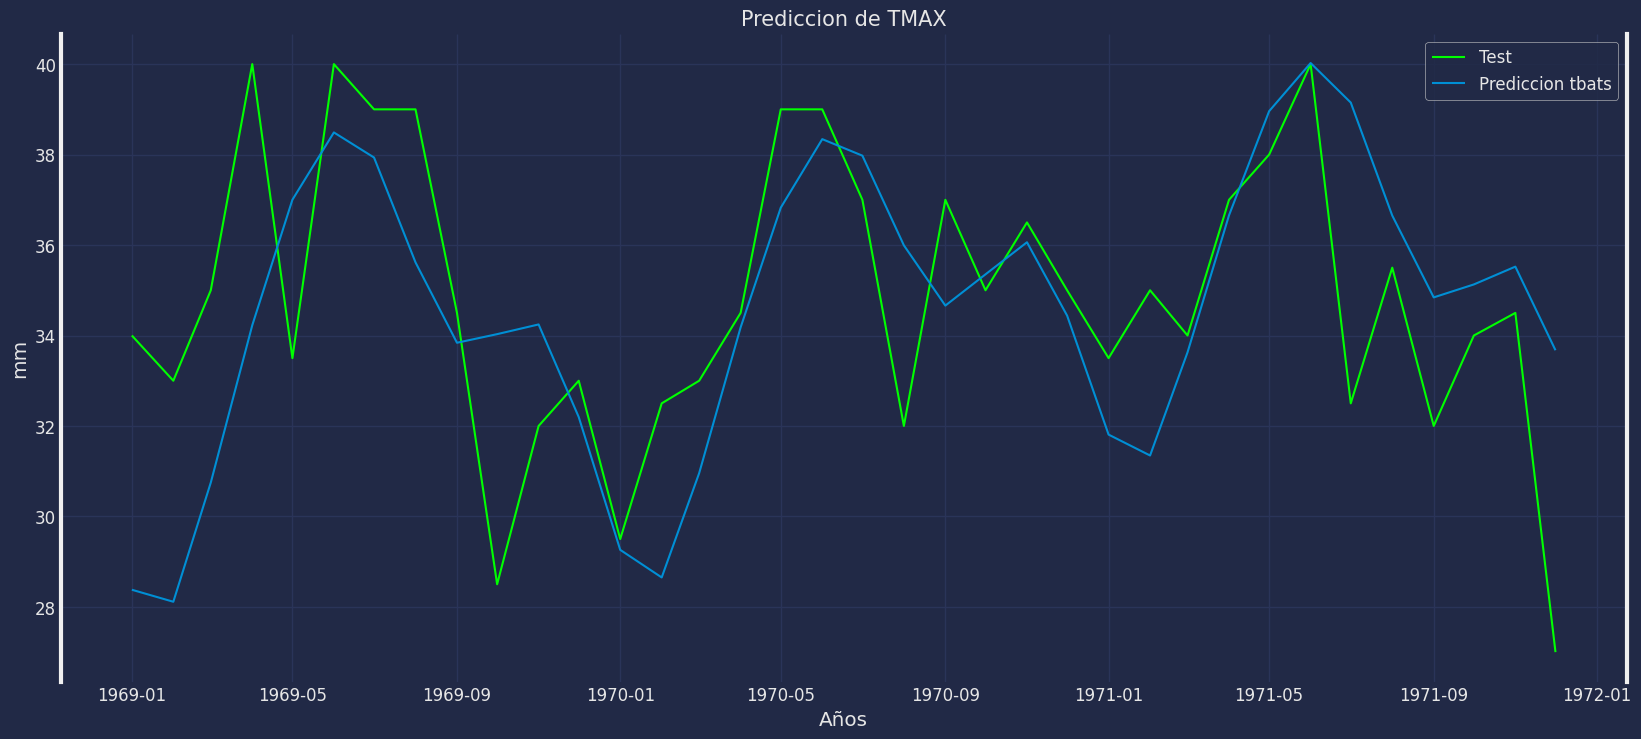

In [40]:
plt.figure(figsize=(18, 8))

plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion tbats")
plt.title("Prediccion de TMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

In [46]:
B=metricas(y_test,y_preds_tbats,"Tbats").T
B

,Tbats
MAE,2.32
RMSE_,3.05
MAPE,0.07
SMAPE,0.07


#Data Transformation

In [24]:
#tbats model
model = TBATS(seasonal_periods = [7, 365.5])
model = model.fit(training_set['PRECIP'])

#Procesando la variable TMIN

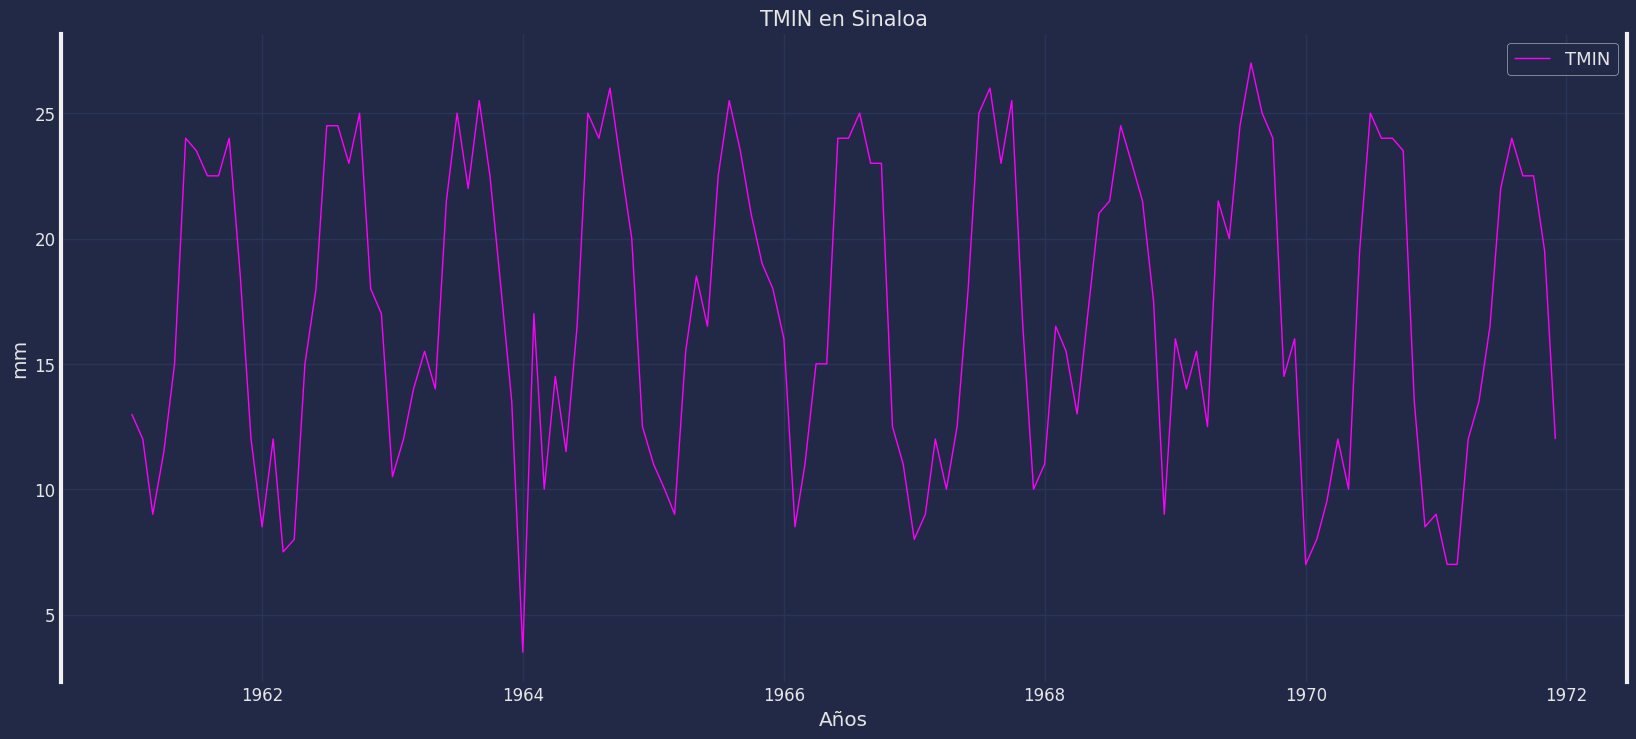

In [6]:
plt.figure(figsize=(18, 8))
plt.plot(data['TMIN'],color="Magenta",linewidth=1)
plt.title('TMIN en Sinaloa',fontsize=15)
plt.xlabel("Años")
plt.ylabel('mm')
plt.legend(['TMIN'],fontsize=13)
plt.show()

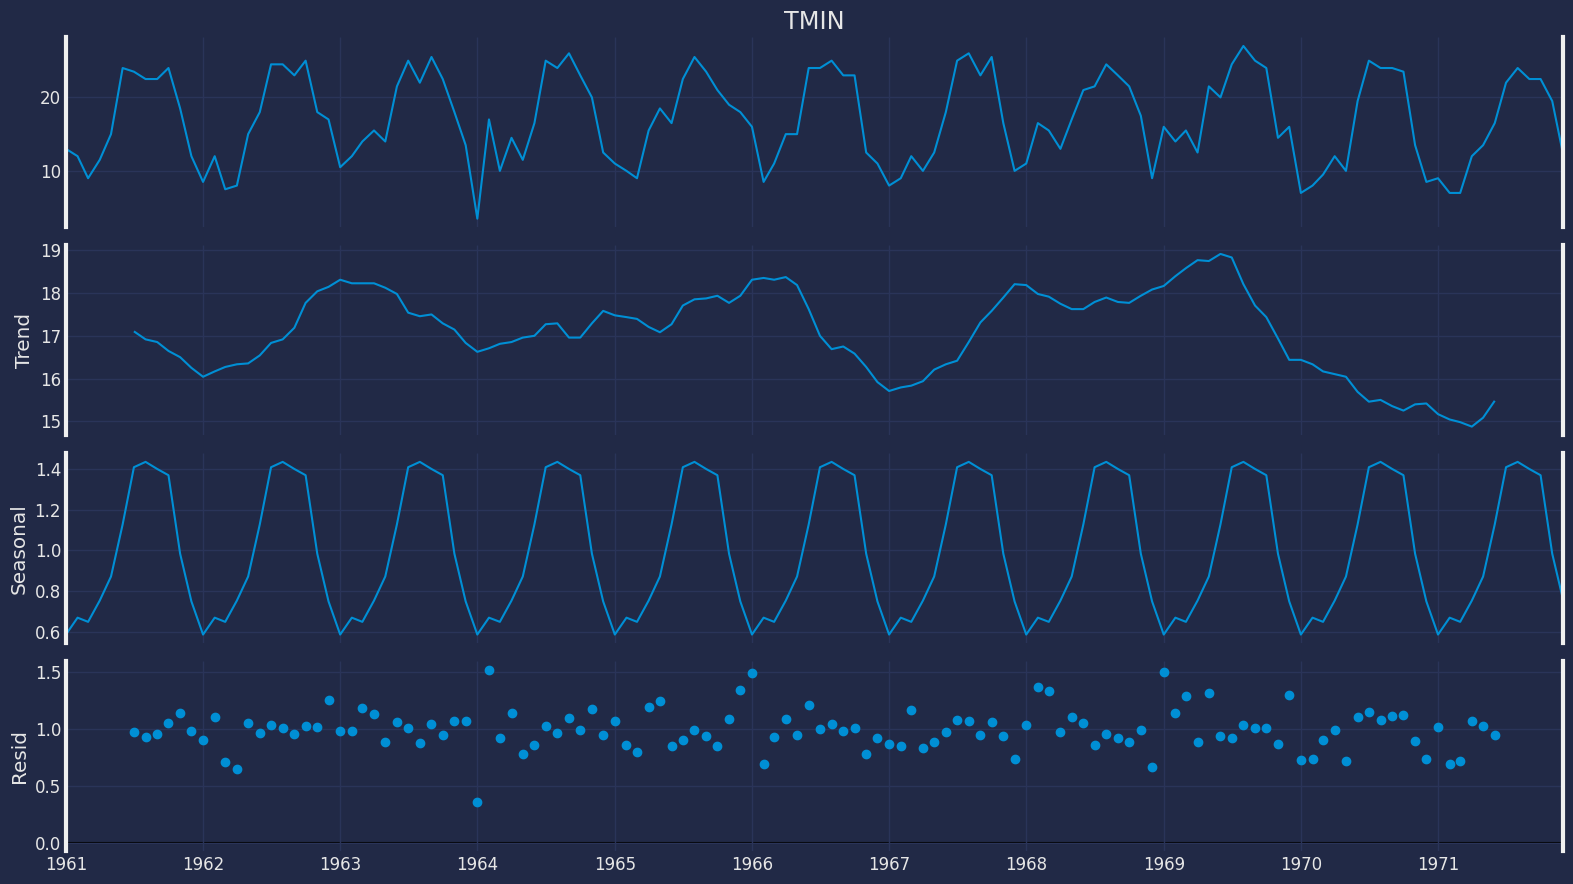

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
a=seasonal_decompose(data['TMIN'],model='multiplicative',period=12)
fig = a.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

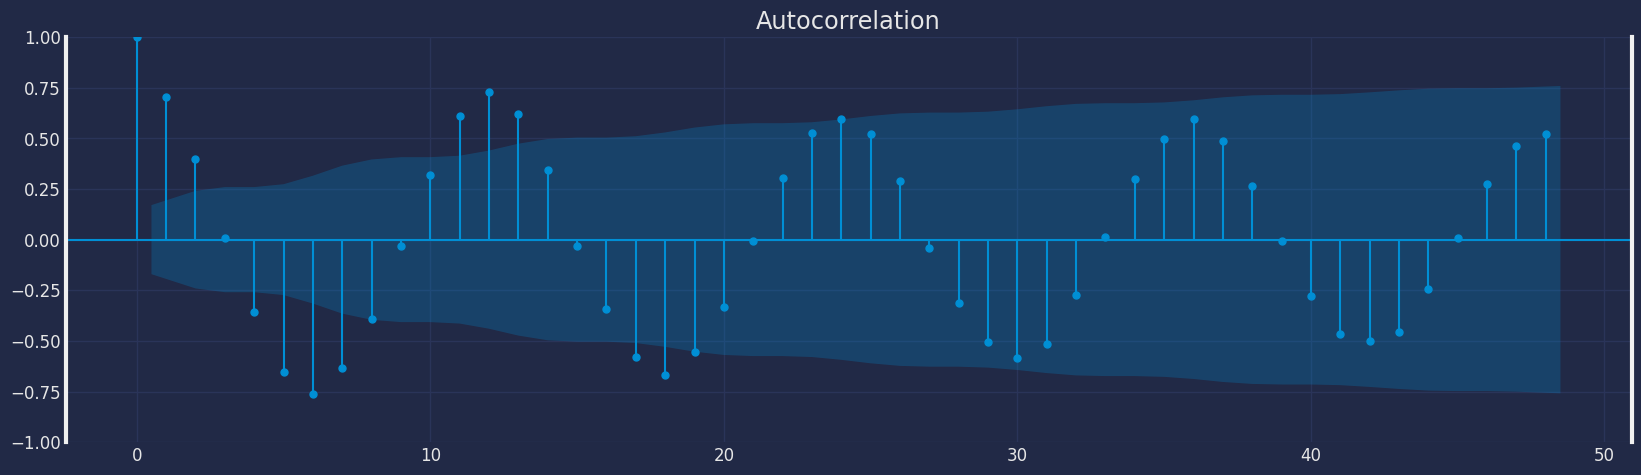

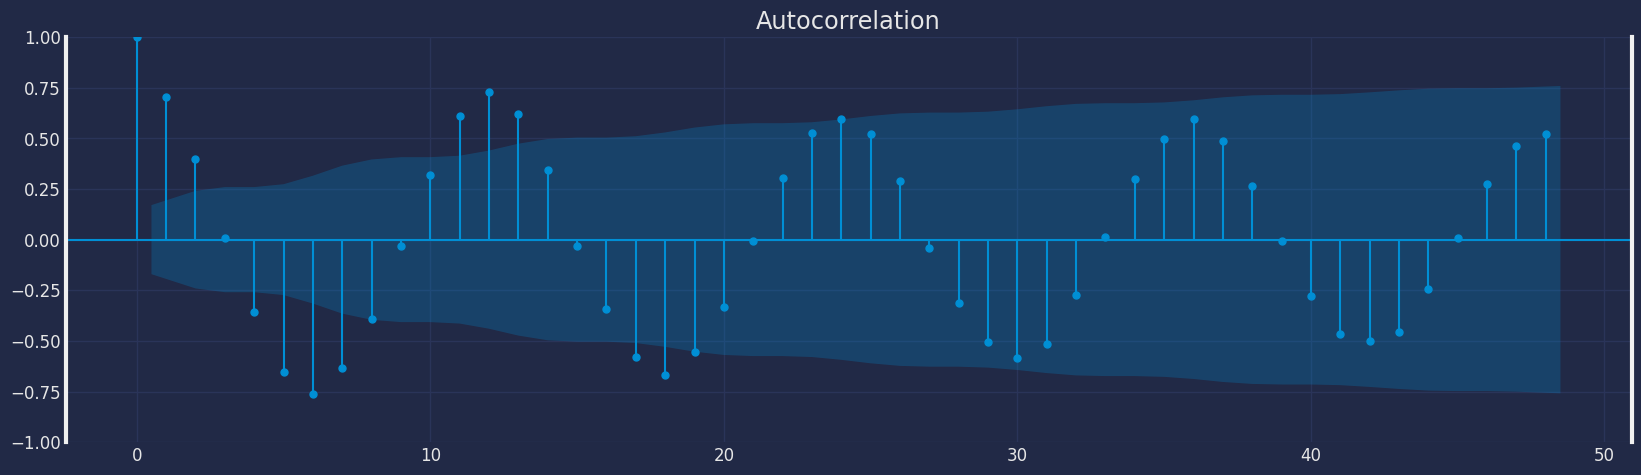

In [8]:
fig,ax=plt.subplots(figsize=(18,5))
plot_acf(data['TMIN'],lags=48,ax=ax)

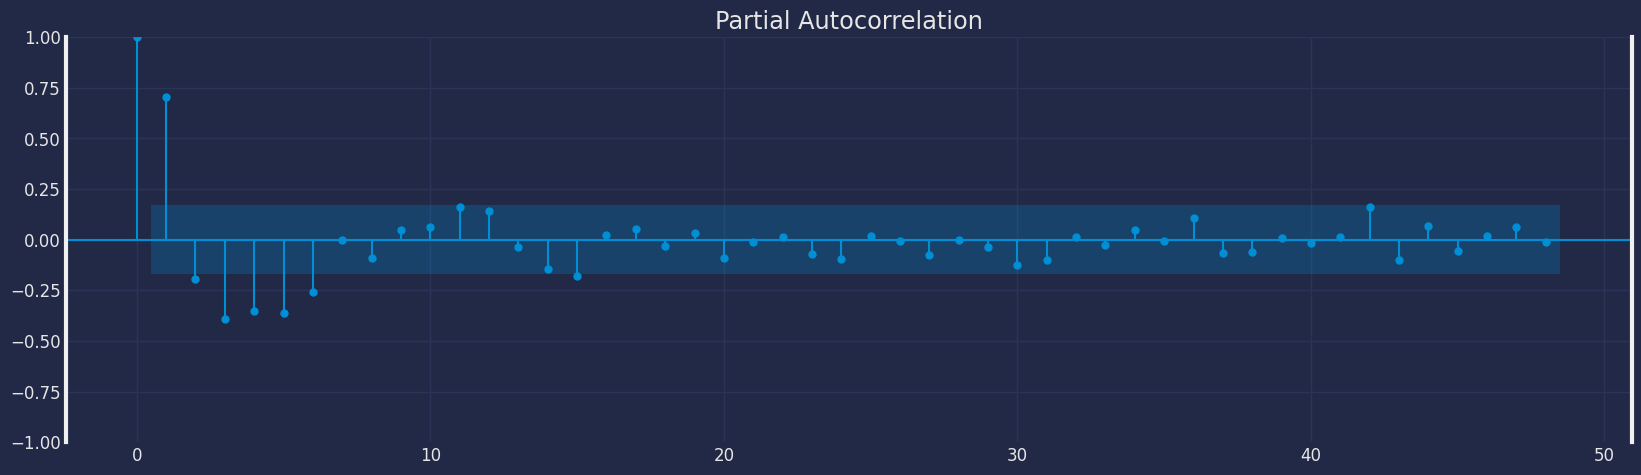

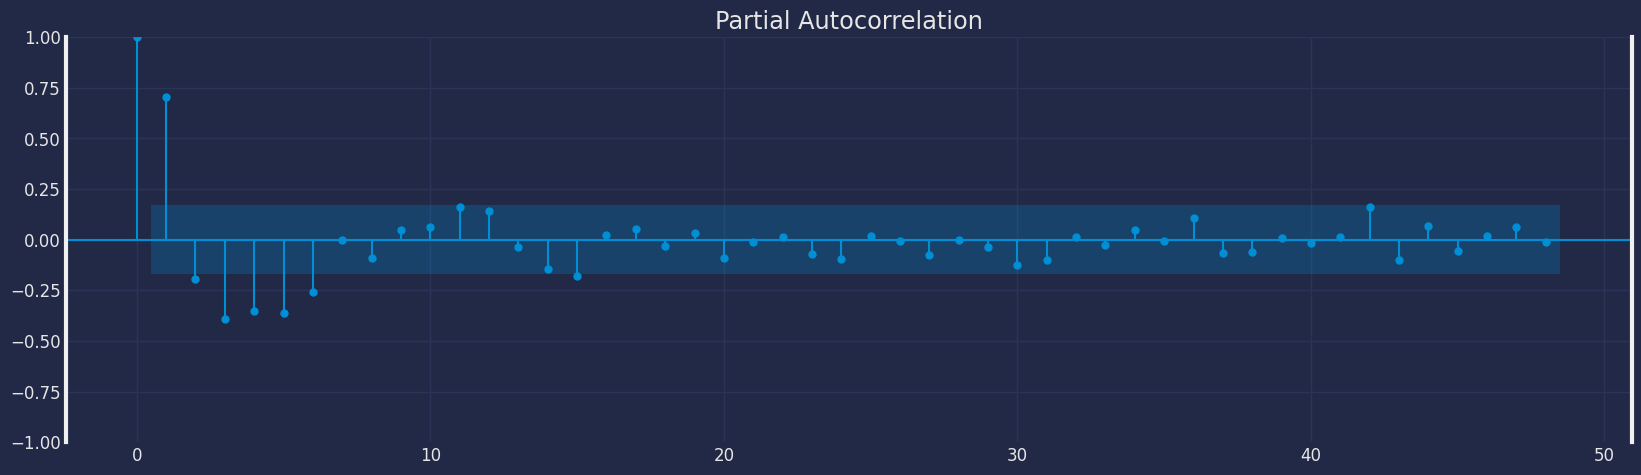

In [9]:
fig,ax=plt.subplots(figsize=(18,5))
plot_pacf(data['TMIN'],lags=48,ax=ax)

In [10]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['TMIN'],test_size=36)
y_train1, y_test1=temporal_train_test_split(data['TMIN'],test_size=36)
y_train.head(10)

FECHA
1961-01-01    13.0
1961-02-01    12.0
1961-03-01     9.0
1961-04-01    11.5
1961-05-01    15.0
1961-06-01    24.0
1961-07-01    23.5
1961-08-01    22.5
1961-09-01    22.5
1961-10-01    24.0
Freq: MS, Name: TMIN, dtype: float64

In [11]:
forecaster_tbats=TBATS(use_box_cox=True,use_trend=True,use_damped_trend=True,sp=[12,48])
forecaster_tbats.fit(y_train)

TBATS(sp=[12, 48], use_box_cox=True, use_damped_trend=True, use_trend=True)

In [23]:
y_preds_tbats=forecaster_tbats.predict(fh)
y_preds_tbats

FECHA
1969-01-01    10.040477
1969-02-01    10.725220
1969-03-01    11.528352
1969-04-01    12.079143
1969-05-01    14.691205
1969-06-01    19.957645
1969-07-01    23.761063
1969-08-01    23.951197
1969-09-01    23.947959
1969-10-01    22.867487
1969-11-01    17.525236
1969-12-01    12.022621
1970-01-01    10.091394
1970-02-01    10.722640
1970-03-01    11.473748
1970-04-01    11.976382
1970-05-01    14.520474
1970-06-01    19.675623
1970-07-01    23.379043
1970-08-01    23.532185
1970-09-01    23.507072
1970-10-01    22.436405
1970-11-01    17.195004
1970-12-01    11.801261
1971-01-01     9.913936
1971-02-01    10.546870
1971-03-01    11.303173
1971-04-01    11.820178
1971-05-01    14.361345
1971-06-01    19.505300
1971-07-01    23.234586
1971-08-01    23.448134
1971-09-01    23.486330
1971-10-01    22.477704
1971-11-01    17.273221
1971-12-01    11.886151
Freq: MS, Name: TMIN, dtype: float64

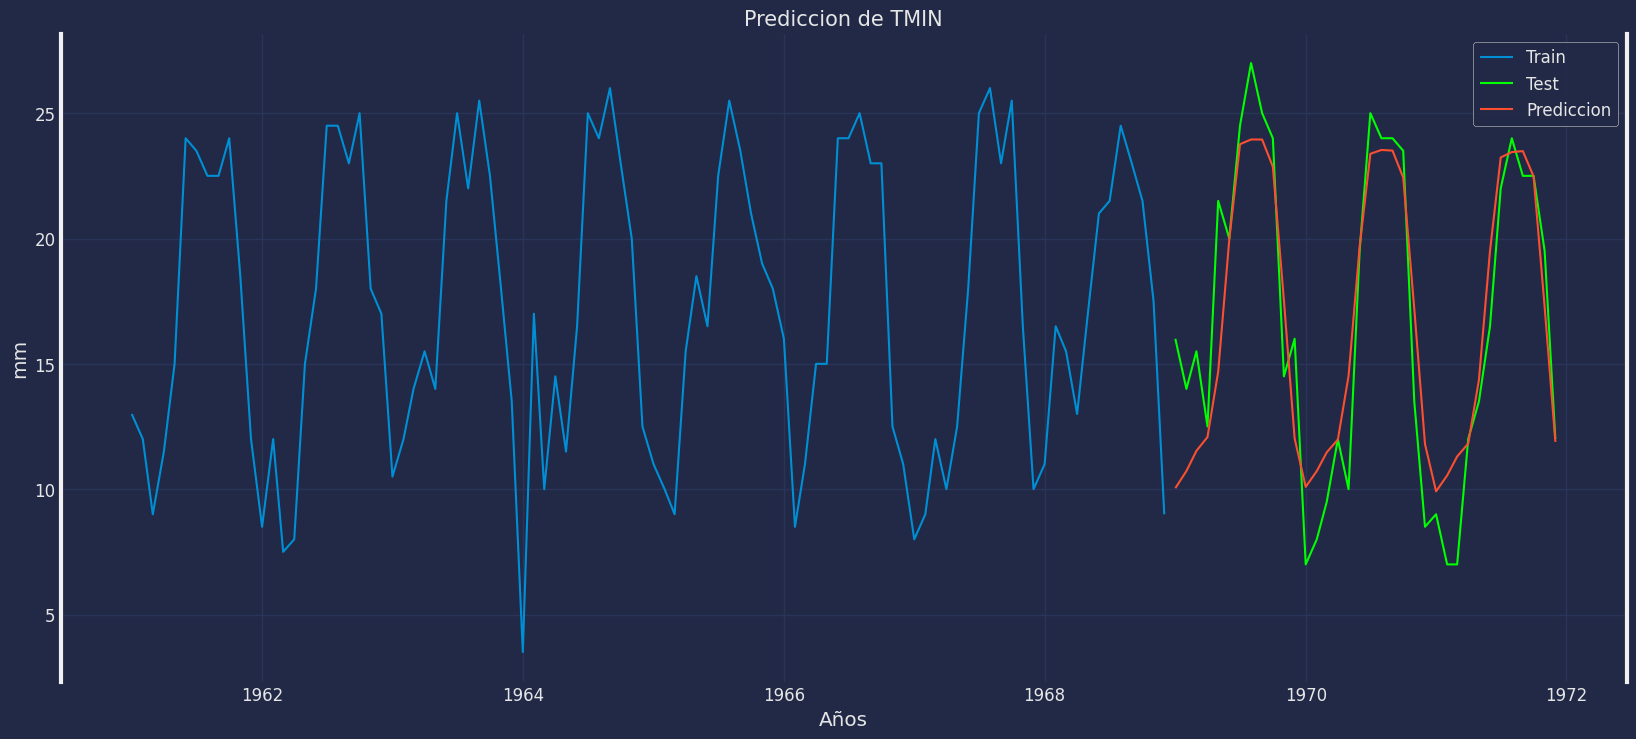

In [24]:
plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion")
plt.title("Prediccion de TMIN",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

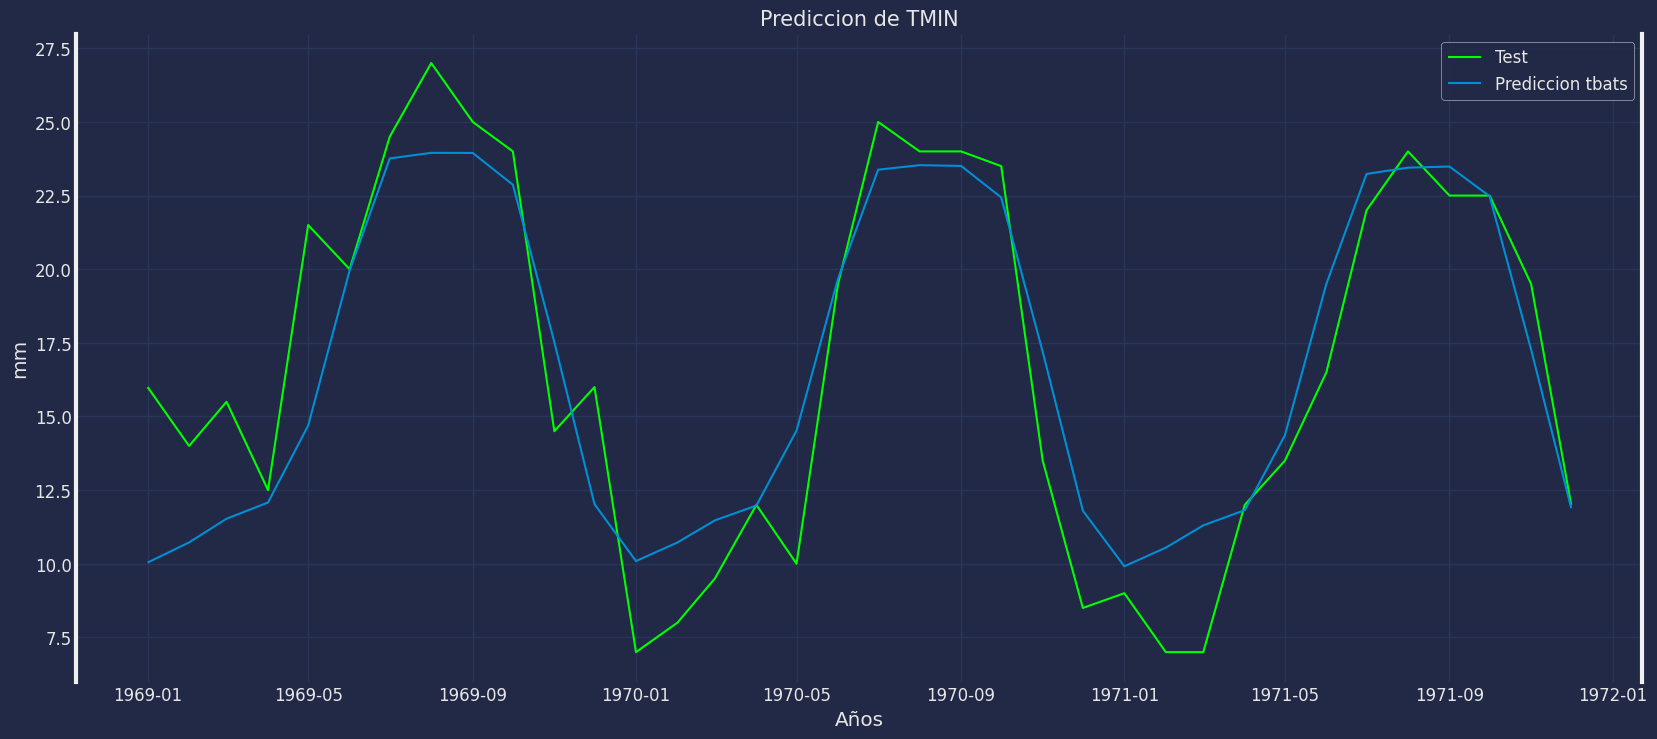

In [25]:
plt.figure(figsize=(18, 8))

plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion tbats")
plt.title("Prediccion de TMIN",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

In [26]:
B=metricas(y_test,y_preds_tbats,"Tbats").T
B

,Tbats
MAE,2.07
RMSE_,2.72
MAPE,0.16
SMAPE,0.15


Procesando la variable EVAP

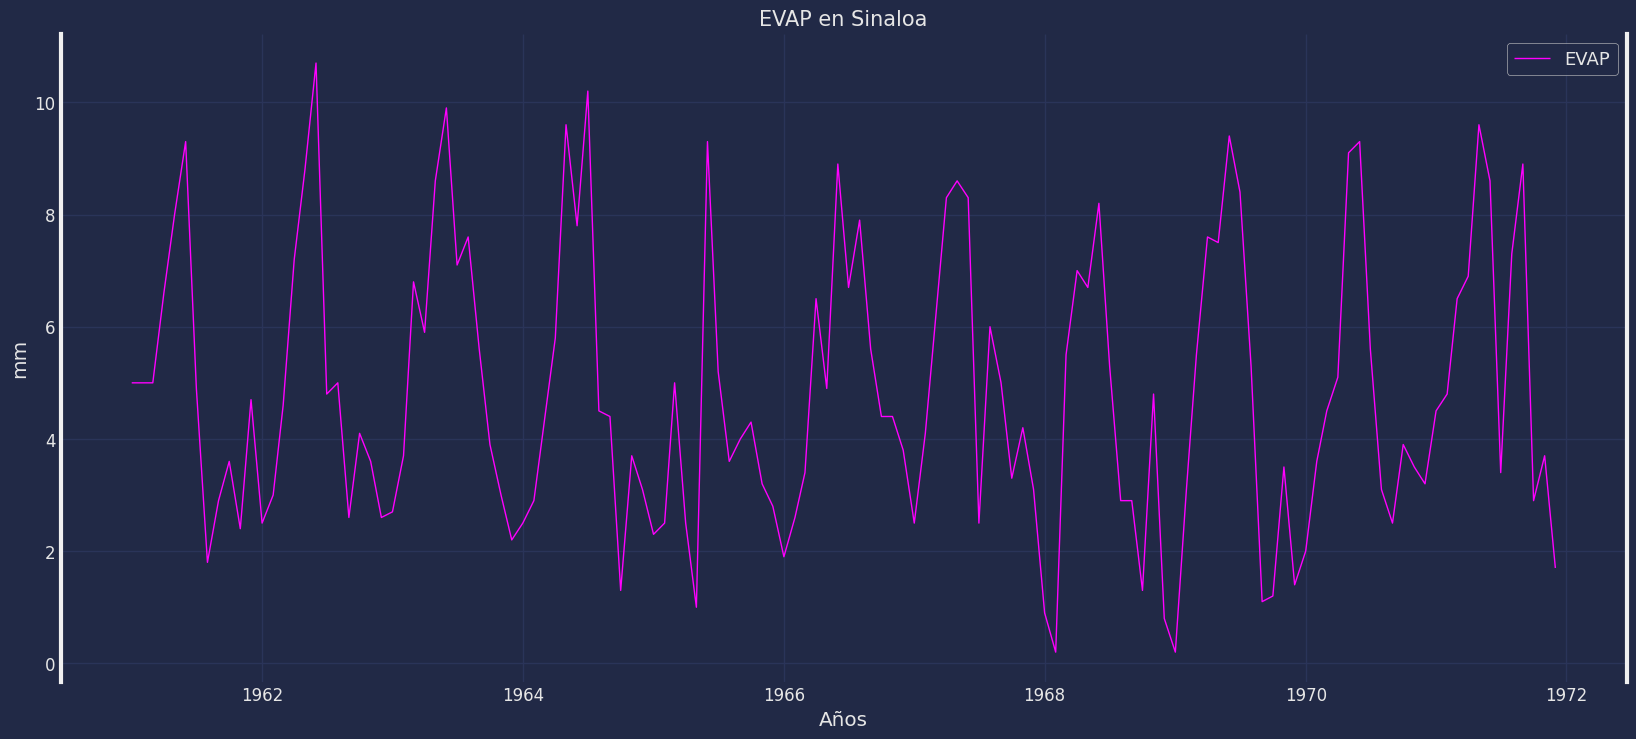

In [32]:
plt.figure(figsize=(18, 8))
plt.plot(data['EVAP'],color="Magenta",linewidth=1)
plt.title('EVAP en Sinaloa',fontsize=15)
plt.xlabel("Años")
plt.ylabel('mm')
plt.legend(['EVAP'],fontsize=13)
plt.show()

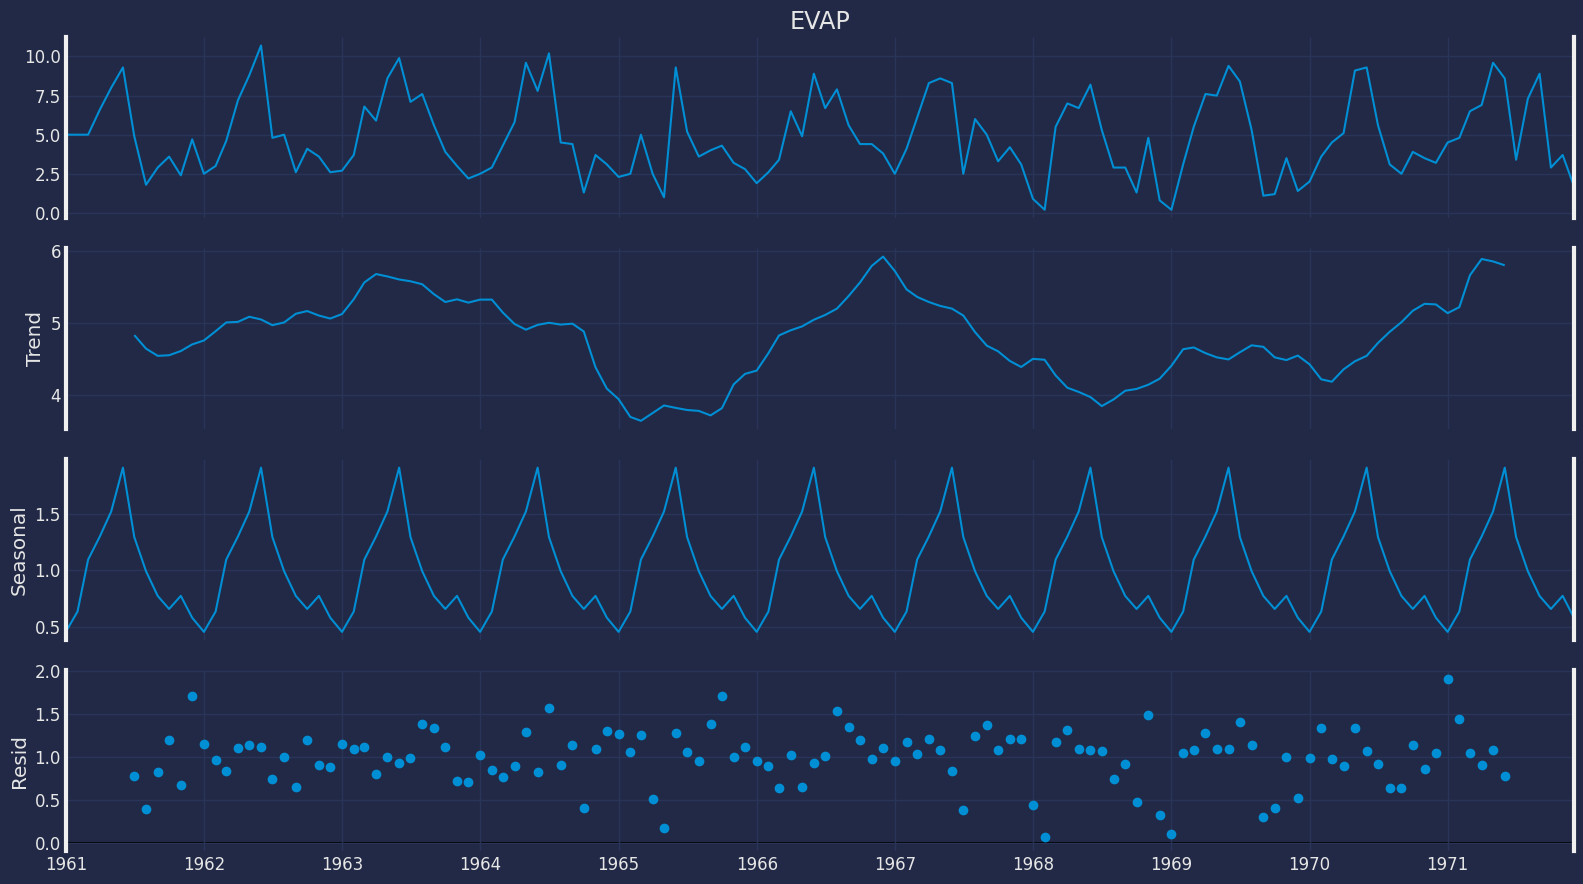

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
a=seasonal_decompose(data['EVAP'],model='multiplicative',period=12)
fig = a.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

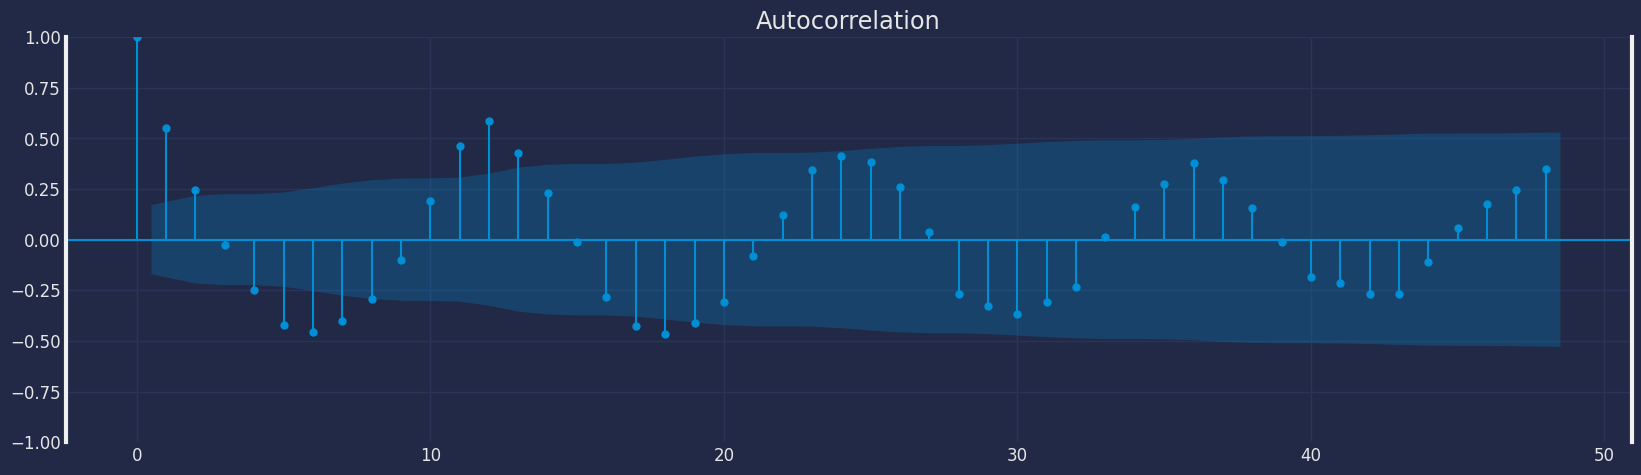

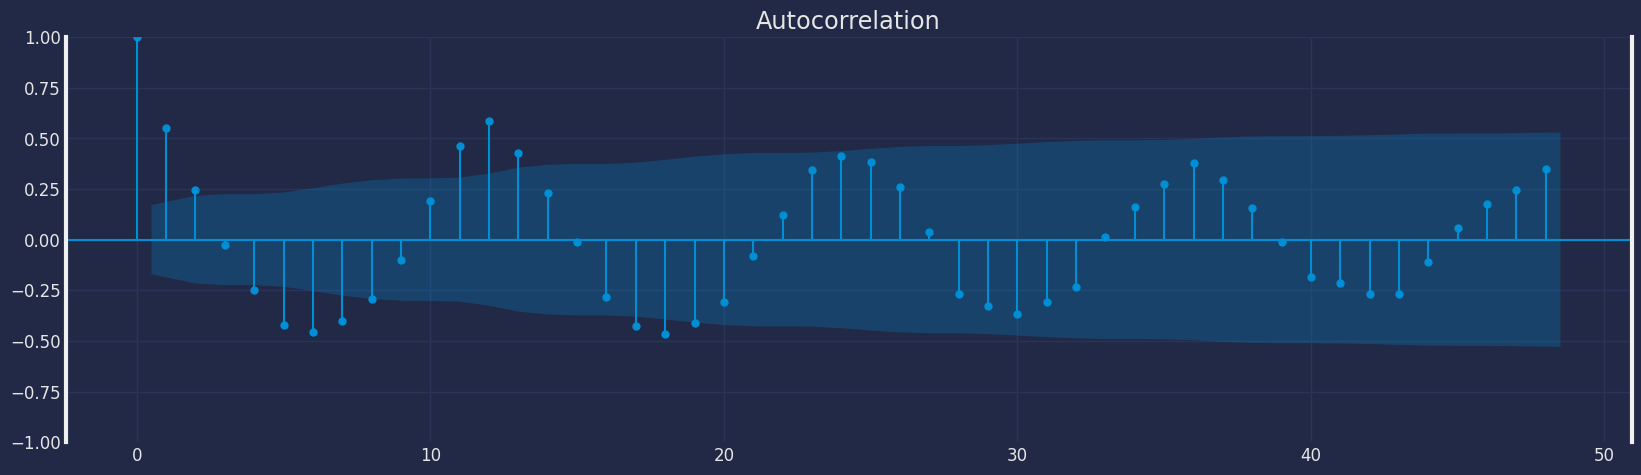

In [34]:
fig,ax=plt.subplots(figsize=(18,5))
plot_acf(data['EVAP'],lags=48,ax=ax)

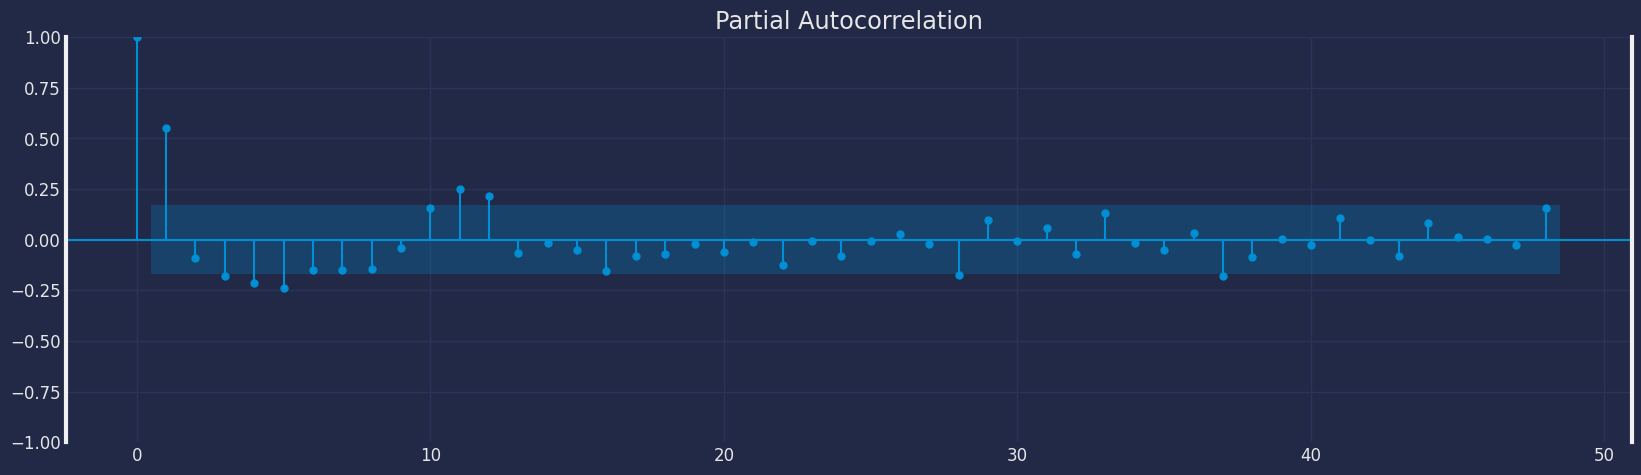

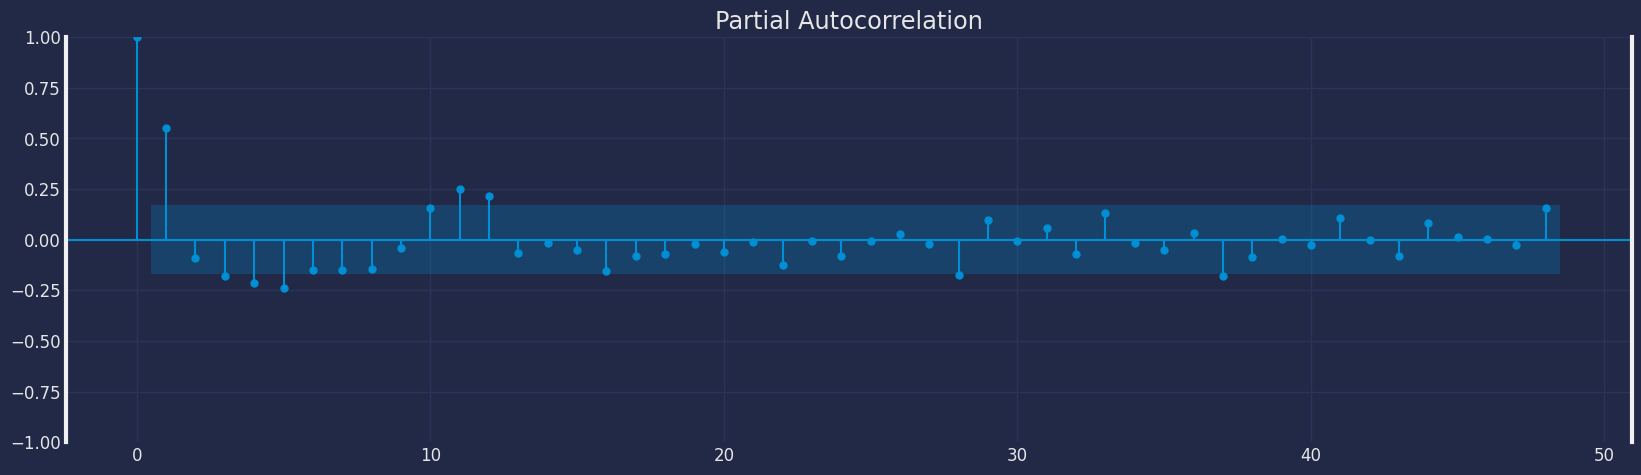

In [35]:
fig,ax=plt.subplots(figsize=(18,5))
plot_pacf(data['EVAP'],lags=48,ax=ax)

In [41]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['EVAP'],test_size=36)
y_train1, y_test1=temporal_train_test_split(data['EVAP'],test_size=36)
y_train.head(10)

FECHA
1961-01-01    5.0
1961-02-01    5.0
1961-03-01    5.0
1961-04-01    6.6
1961-05-01    8.0
1961-06-01    9.3
1961-07-01    4.9
1961-08-01    1.8
1961-09-01    2.9
1961-10-01    3.6
Freq: MS, Name: EVAP, dtype: float64

In [46]:
forecaster_tbats=TBATS(use_box_cox=True,use_trend=True,use_damped_trend=True,sp=[12,12])
forecaster_tbats.fit(y_train)

TBATS(sp=[12, 12], use_box_cox=True, use_damped_trend=True, use_trend=True)

In [47]:

fh=ForecastingHorizon(y_test.index,is_relative=False)
y_preds_tbats=forecaster_tbats.predict(fh)
y_preds_tbats

FECHA
1969-01-01    1.712988
1969-02-01    2.105325
1969-03-01    4.508891
1969-04-01    5.547997
1969-05-01    6.631165
1969-06-01    8.537523
1969-07-01    5.547704
1969-08-01    4.455700
1969-09-01    3.891367
1969-10-01    2.860114
1969-11-01    3.461437
1969-12-01    2.493167
1970-01-01    2.145066
1970-02-01    2.451218
1970-03-01    4.786395
1970-04-01    5.770175
1970-05-01    6.809029
1970-06-01    8.679955
1970-07-01    5.661455
1970-08-01    4.546621
1970-09-01    3.964065
1970-10-01    2.918201
1970-11-01    3.507941
1970-12-01    2.530322
1971-01-01    2.174771
1971-02-01    2.474995
1971-03-01    4.805467
1971-04-01    5.785444
1971-05-01    6.821252
1971-06-01    8.689744
1971-07-01    5.669272
1971-08-01    4.552869
1971-09-01    3.969061
1971-10-01    2.922192
1971-11-01    3.511136
1971-12-01    2.532875
Freq: MS, Name: EVAP, dtype: float64

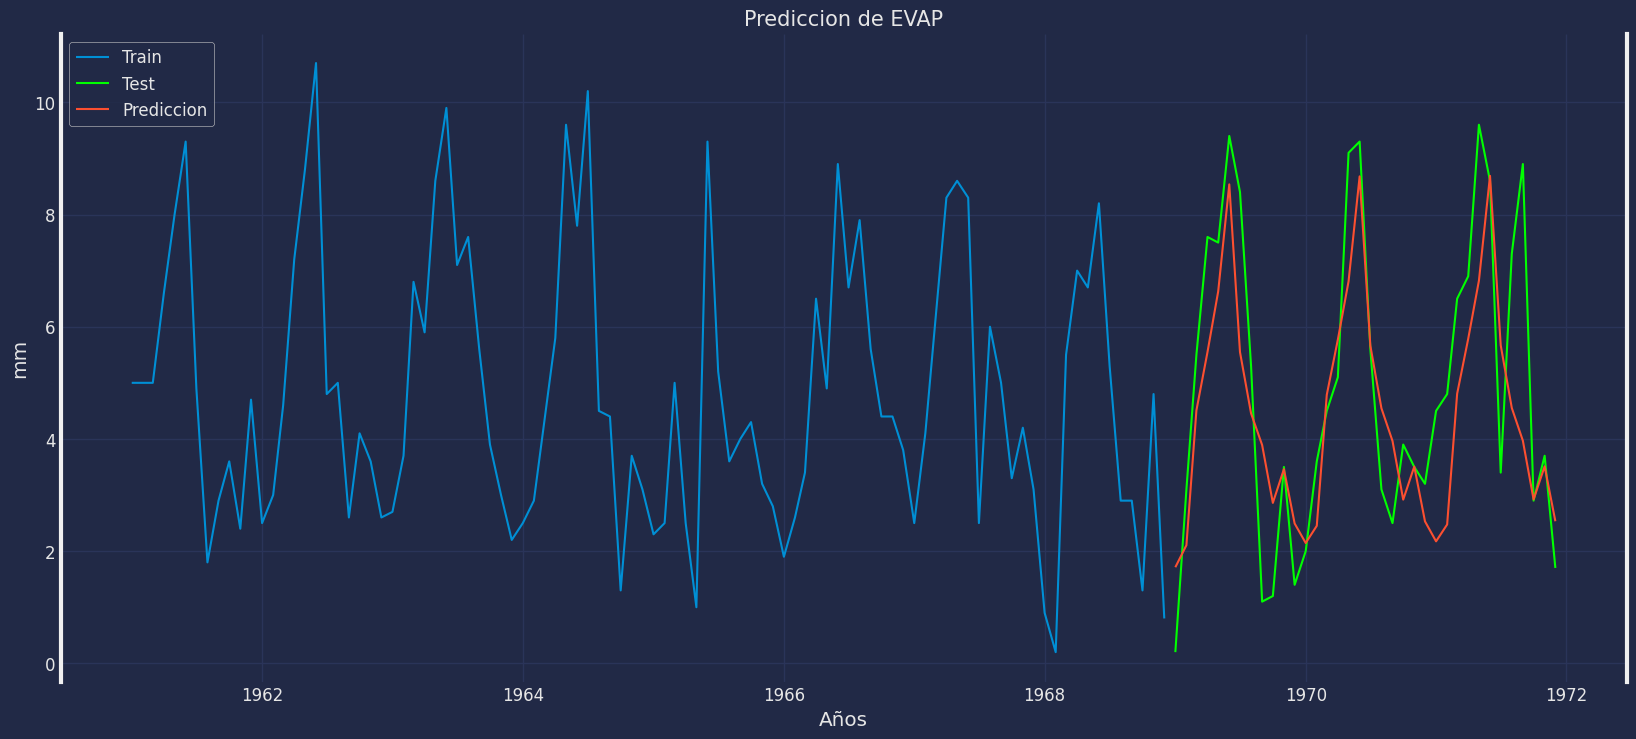

In [48]:
plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion")
plt.title("Prediccion de EVAP",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

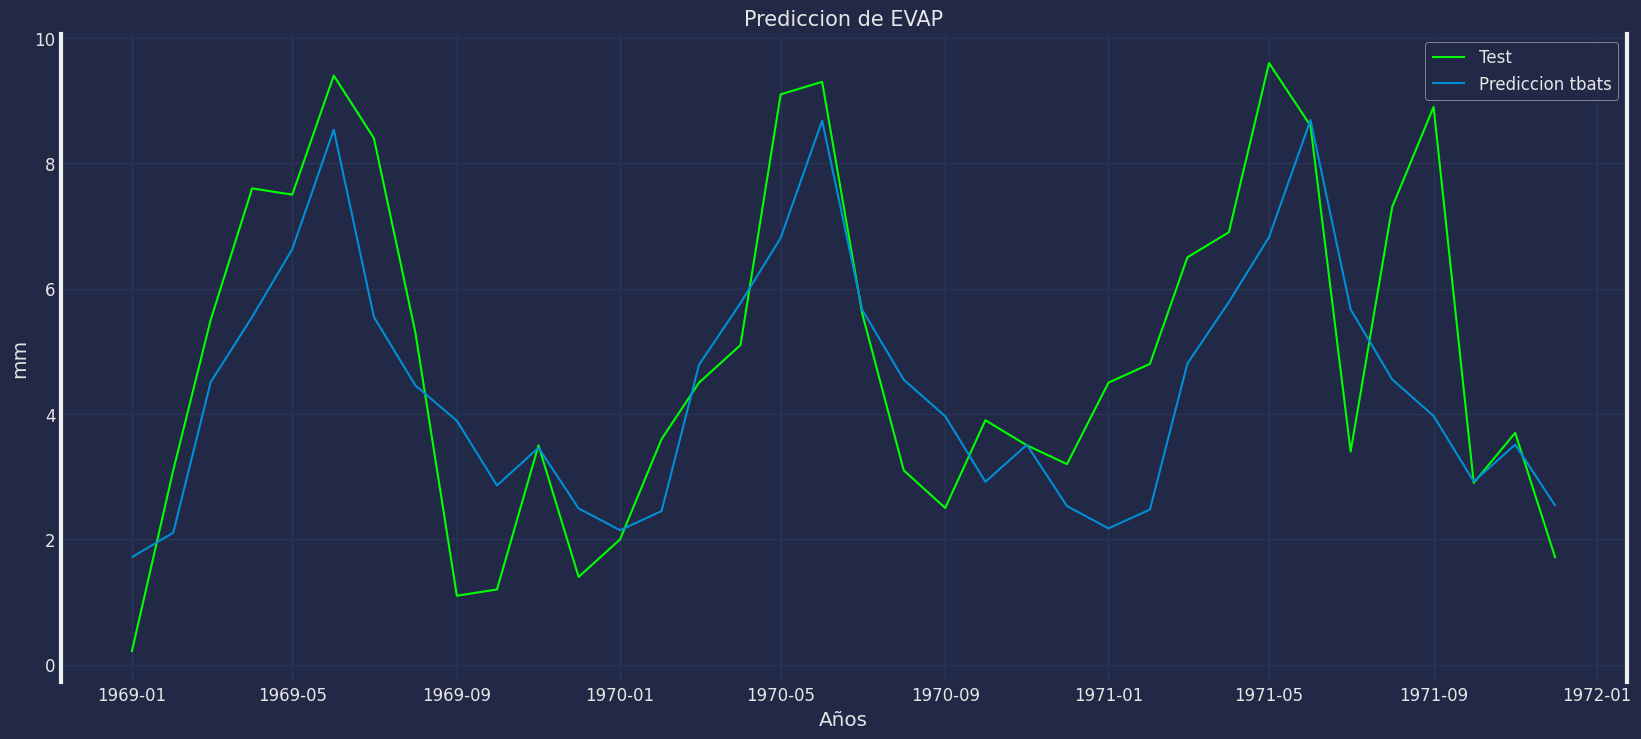

In [49]:
plt.figure(figsize=(18, 8))

plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion tbats")
plt.title("Prediccion de EVAP",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

In [50]:
B=metricas(y_test,y_preds_tbats,"Tbats").T
B

,Tbats
MAE,1.32
RMSE_,1.70
MAPE,0.56
SMAPE,0.35


Pronostico de variable PRECIP

In [68]:
data.index = pd.to_datetime(data.index,
                            format = "%d/%m/%Y")
data.head(2)   
data = data.asfreq("MS")
data.index    

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01',
               ...
               '1971-03-01', '1971-04-01', '1971-05-01', '1971-06-01',
               '1971-07-01', '1971-08-01', '1971-09-01', '1971-10-01',
               '1971-11-01', '1971-12-01'],
              dtype='datetime64[ns]', name='FECHA', length=132, freq='MS')

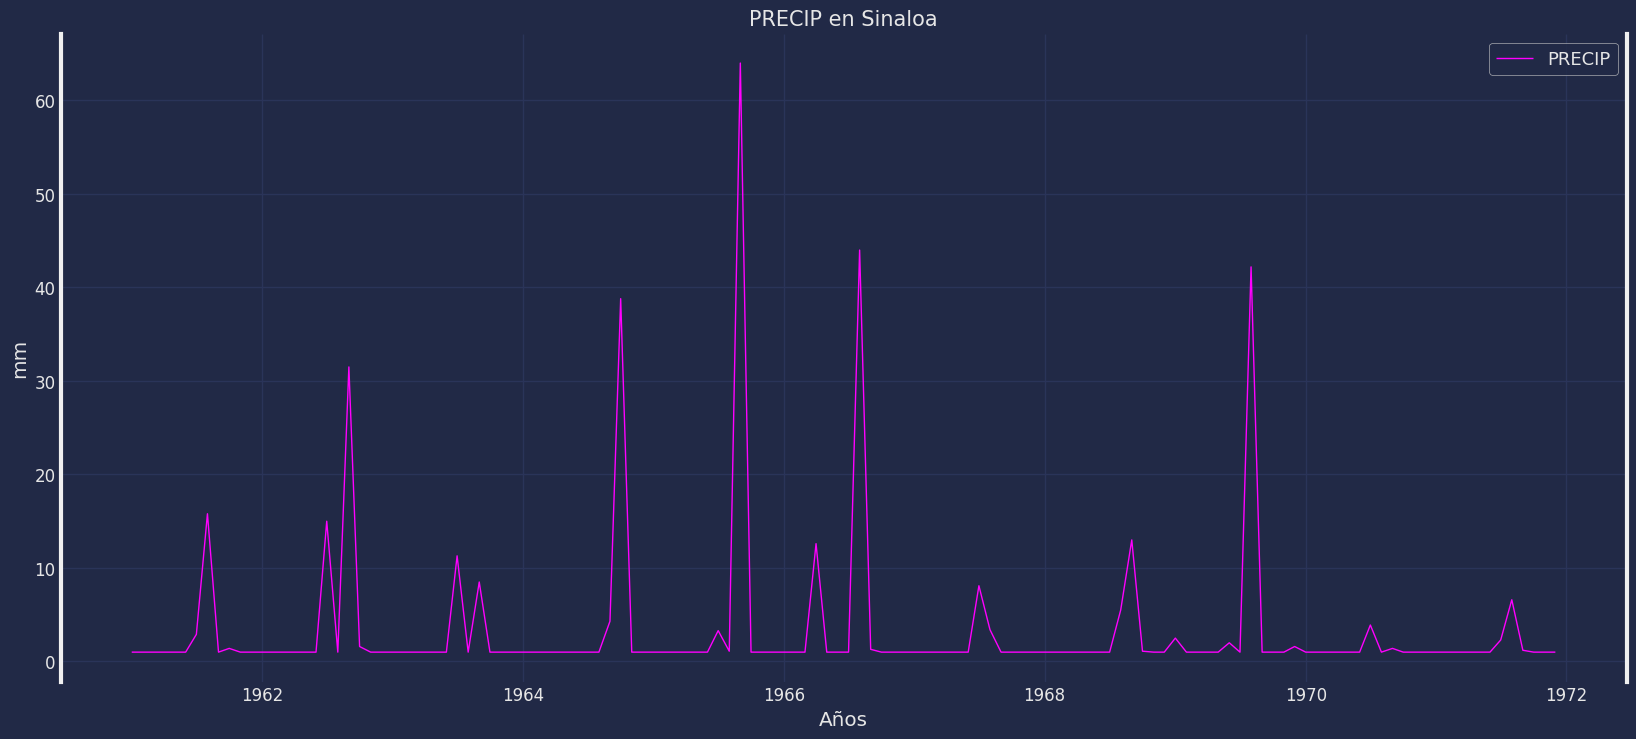

In [69]:
plt.figure(figsize=(18, 8))
plt.plot(data['PRECIP'],color="Magenta",linewidth=1)
plt.title('PRECIP en Sinaloa',fontsize=15)
plt.xlabel("Años")
plt.ylabel('mm')
plt.legend(['PRECIP'],fontsize=13)
plt.show()

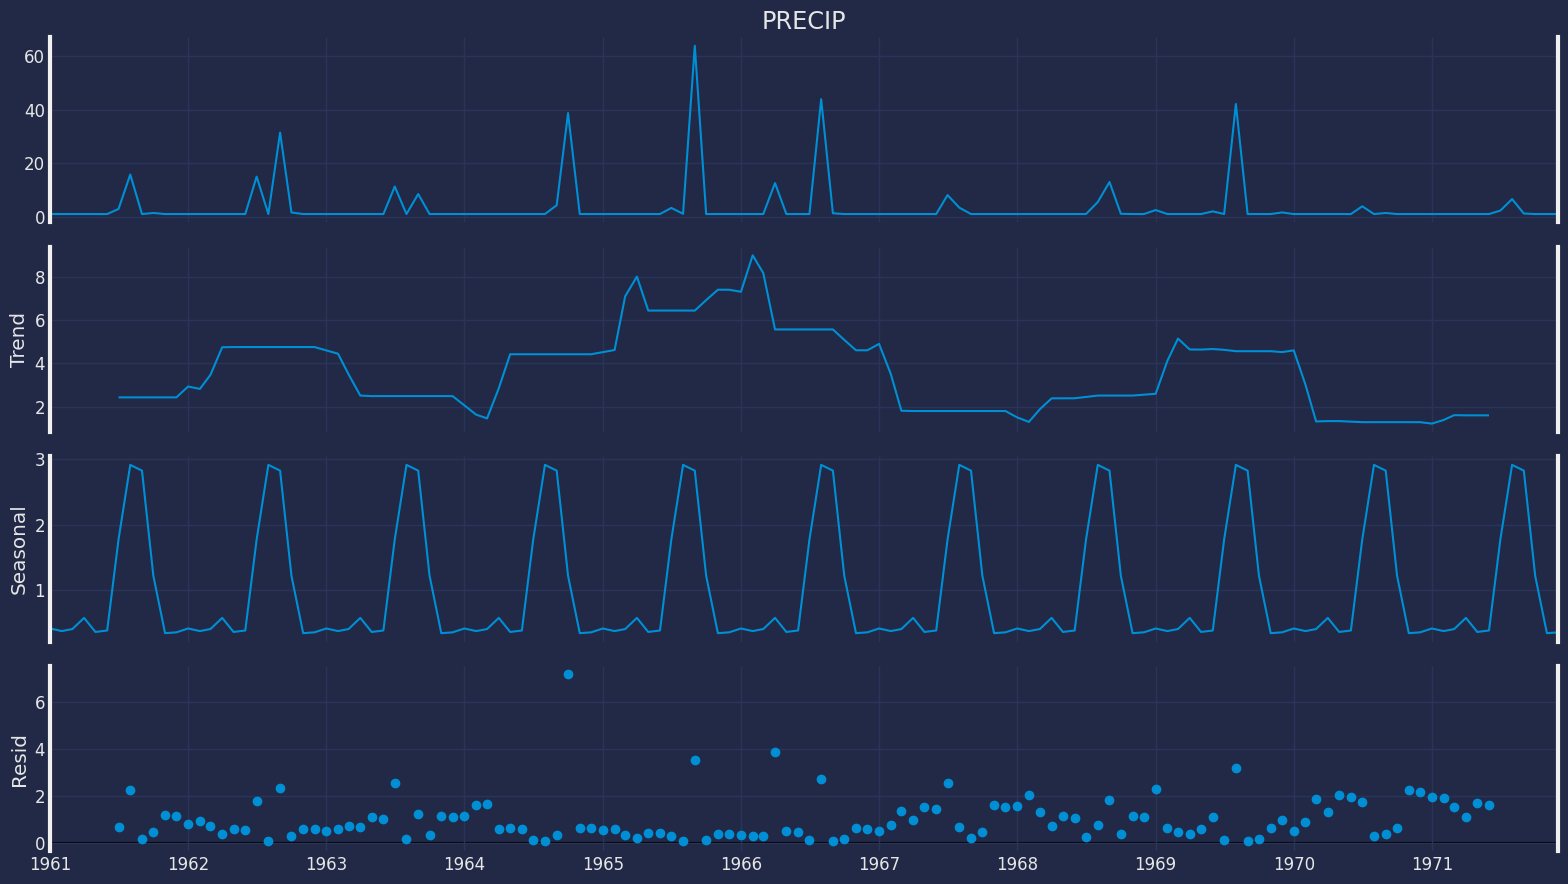

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
a=seasonal_decompose(data['PRECIP'],model='multiplicative',period=12)
fig = a.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

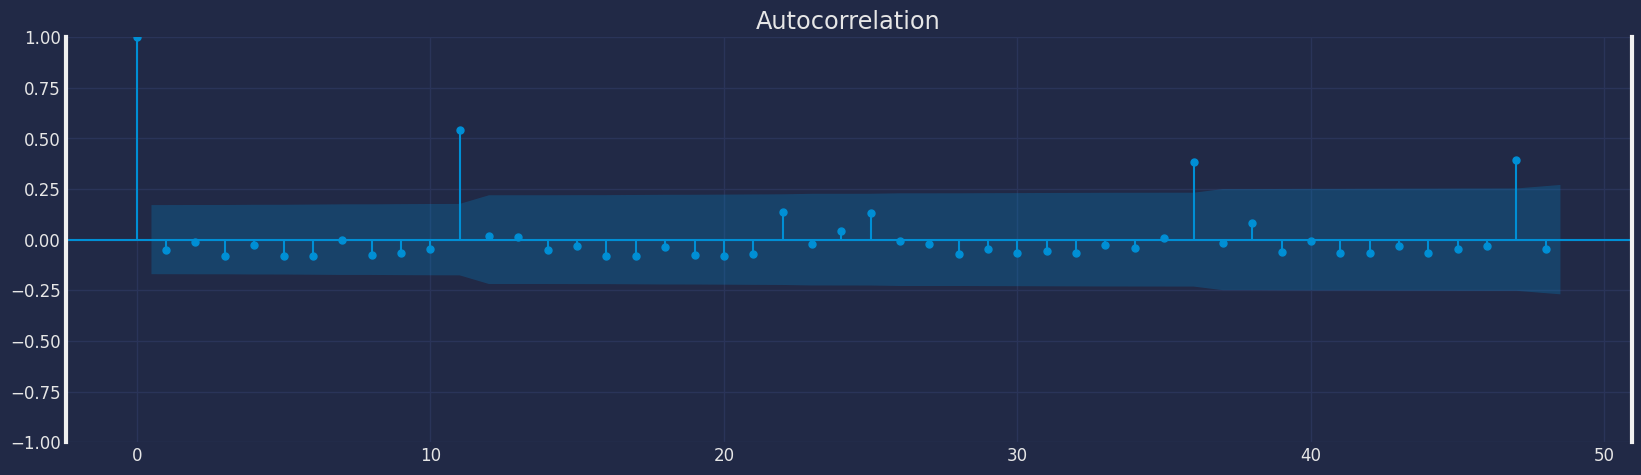

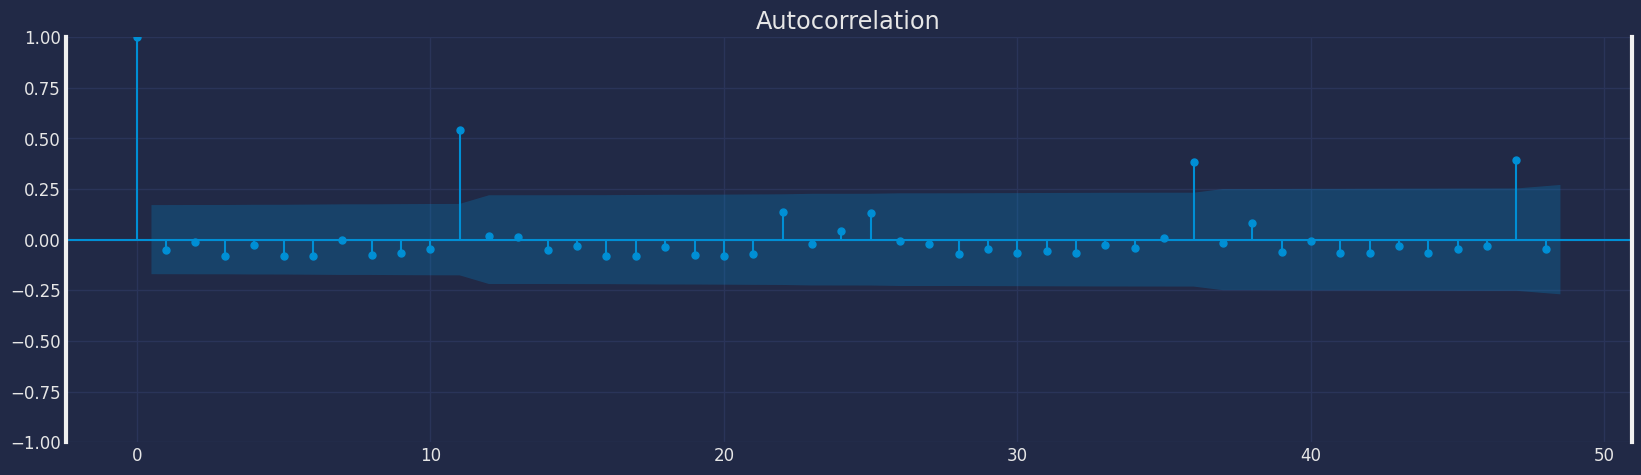

In [72]:
fig,ax=plt.subplots(figsize=(18,5))
plot_acf(data['PRECIP'],lags=48,ax=ax)

In [73]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['PRECIP'],test_size=36)
y_train1, y_test1=temporal_train_test_split(data['PRECIP'],test_size=36)
y_train.head(10)

FECHA
1961-01-01     1.0
1961-02-01     1.0
1961-03-01     1.0
1961-04-01     1.0
1961-05-01     1.0
1961-06-01     1.0
1961-07-01     2.9
1961-08-01    15.8
1961-09-01     1.0
1961-10-01     1.4
Freq: MS, Name: PRECIP, dtype: float64

In [83]:
forecaster_tbats=TBATS(use_box_cox=True,use_trend=True,use_damped_trend=True,sp=[12,60])
forecaster_tbats.fit(y_train)

TBATS(sp=[12, 60], use_box_cox=True, use_damped_trend=True, use_trend=True)

In [84]:
fh=ForecastingHorizon(y_test.index,is_relative=False)
y_preds_tbats=forecaster_tbats.predict(fh)
y_preds_tbats

FECHA
1969-01-01    0.861733
1969-02-01    1.213209
1969-03-01    1.371305
1969-04-01    1.238659
1969-05-01    1.237275
1969-06-01    1.828505
1969-07-01    3.643910
1969-08-01    6.262766
1969-09-01    6.196866
1969-10-01    3.600785
1969-11-01    1.896976
1969-12-01    1.428883
1970-01-01    1.670444
1970-02-01    2.224952
1970-03-01    2.402096
1970-04-01    2.085286
1970-05-01    2.009146
1970-06-01    2.868981
1970-07-01    5.526750
1970-08-01    9.178279
1970-09-01    8.767851
1970-10-01    4.913925
1970-11-01    2.494878
1970-12-01    1.810217
1971-01-01    2.038465
1971-02-01    2.616708
1971-03-01    2.725583
1971-04-01    2.286543
1971-05-01    2.133515
1971-06-01    2.957930
1971-07-01    5.548105
1971-08-01    8.998502
1971-09-01    8.421328
1971-10-01    4.637760
1971-11-01    2.320342
1971-12-01    1.663249
Freq: MS, Name: PRECIP, dtype: float64

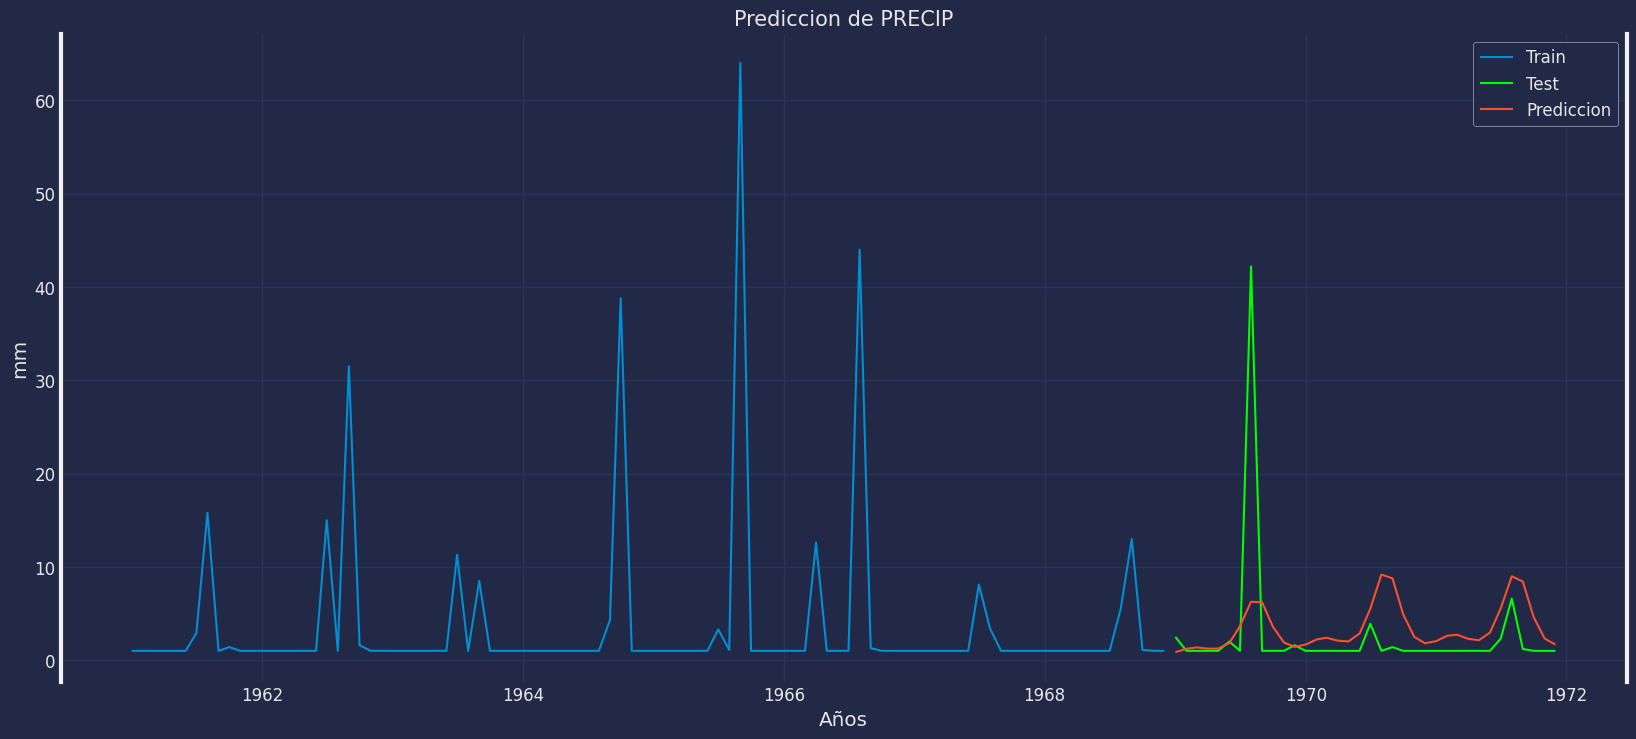

In [85]:
plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion")
plt.title("Prediccion de PRECIP",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

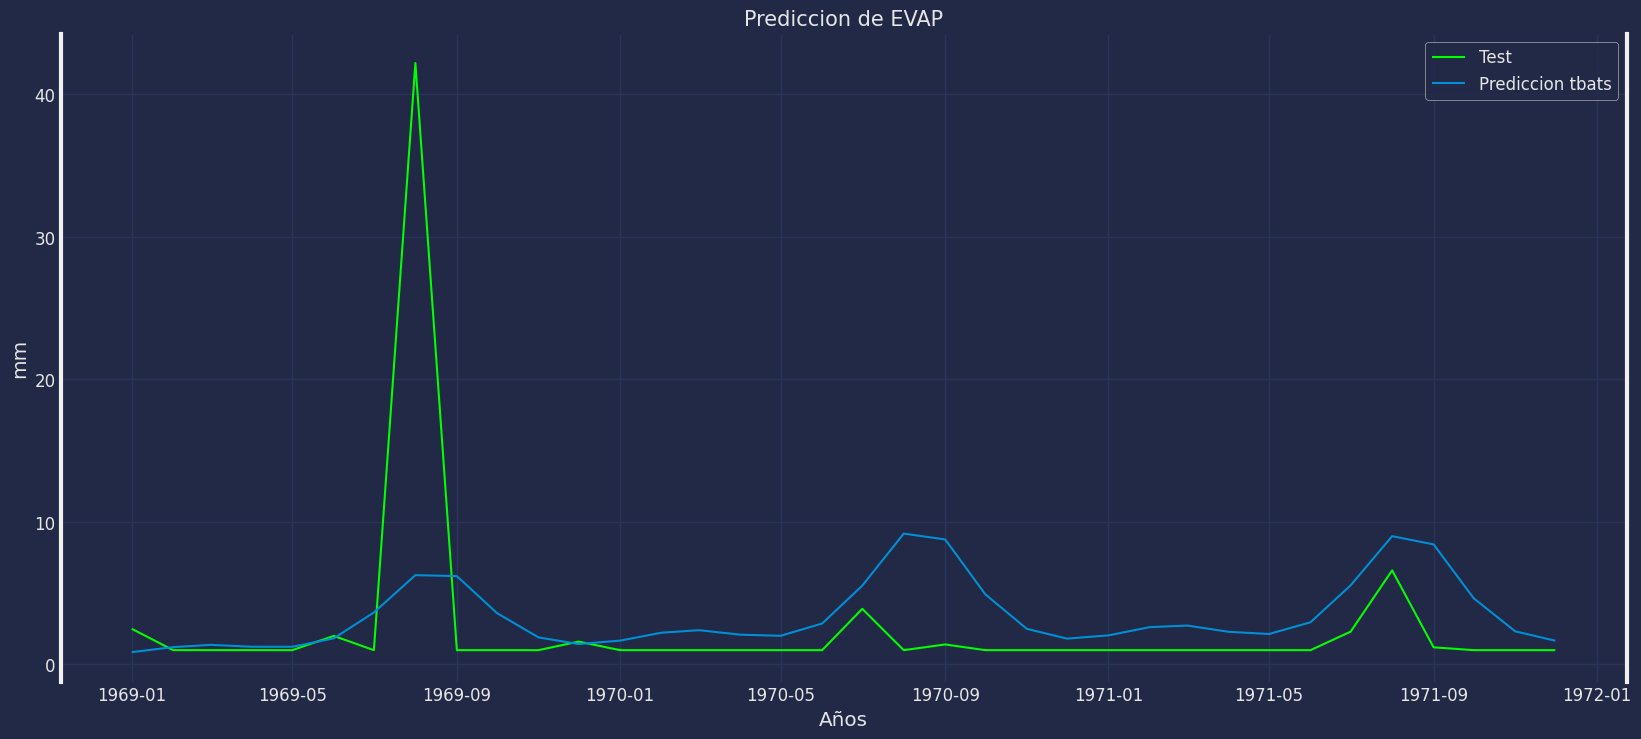

In [86]:
plt.figure(figsize=(18, 8))

plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(y_preds_tbats,label="Prediccion tbats")
plt.title("Prediccion de EVAP",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

In [87]:
B=metricas(y_test,y_preds_tbats,"Tbats").T
B

,Tbats
MAE,3.01
RMSE_,6.64
MAPE,1.77
SMAPE,0.80


#export forecasts